# import

In [1]:
import pandas as pd
import numpy as np
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras import metrics
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
# 시각화 선명도
%config InlineBackend.figure_format = 'retina' 
# 한글설정 축의 깨짐 방지
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
# warining 경고 안보이게
warnings.filterwarnings(action='ignore')
# warining 경고 보이게
# warnings.filterwarnings(action='default')

# .csv concat

In [3]:
folder = '1' # csv있는 폴더
csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
dataframes = [pd.read_csv(os.path.join(folder, file)) for file in csv_files]
movie_df = pd.concat(dataframes, ignore_index=True)
movie_df.to_csv('result/movie_df.csv', index=False, encoding='utf-8')
print(len(movie_df)) # 총 6043
movie = movie_df.copy()

6043


# 영화 장르 결측치 웹크롤링

In [4]:
def genre_nm_none_list(df):
    title_list=[]
    title_list.append(df.loc[df['GENRE_NM'].isna(), 'MOVIE_NM'].values)
    return title_list

In [5]:
result_list = genre_nm_none_list(movie)
movie_title = result_list[0].tolist()
genre_lists = set(movie['GENRE_NM'])

In [6]:
# 동적 웹 크롤링으로 장르 받아오기 (naver)
def naver_crawling_genre(genre_non_list):
    dv = webdriver.Chrome()
    dv.get('http://www.naver.com')
    time.sleep(1.5)
    el = dv.find_element(By.CSS_SELECTOR, 'input#query')
    for title in genre_non_list :
        el.clear()
        el.send_keys('영화 {} 정보'.format(title))
        el.send_keys(Keys.ENTER)
        time.sleep(1.5)
        genres = dv.find_elements(By.CSS_SELECTOR, 'div.info_group dd')[2]
        el = dv.find_element(By.CSS_SELECTOR, 'input#nx_query')
        genre = genres.text.split(', ')[0]
        flag = True
        for word in list(genre_lists):
            if word==genre:
                flag = False
                break;
        if(flag):
            genre = np.nan
        movie.loc[movie['MOVIE_NM']==title, 'GENRE_NM'] = genre
        el.clear()
    dv.close()

In [7]:
naver_crawling_genre(movie_title)
movie.to_csv('result/movie.csv', index=False, encoding='utf-8')
movie = pd.read_csv('result/movie.csv')
movie.head()

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM
0,1,소울,피트 닥터,"월트 디즈니 픽쳐스,픽사 애니메이션 스튜디오",월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,20210120,개봉영화,장편,미국,2018,7936332910,875001,2578880980,275009,애니메이션,전체관람가,일반영화
1,2,극장판 귀멸의 칼날: 무한열차편,소토자키 하루오,NaN,에스엠지홀딩스 주식회사,워터홀컴퍼니(주),20210127,개봉영화,장편,일본,380,1820102670,206309,507360670,54677,애니메이션,15세이상관람가,일반영화
2,3,원더 우먼 1984,팻티 젠킨스,NaN,워너브러더스 코리아(주),워너브러더스 코리아(주),20201223,개봉영화,장편,미국,2260,1445202000,155562,425776520,43999,액션,12세이상관람가,일반영화
3,4,세자매,이승원,(주)영화사 업,NaN,(주)리틀빅픽쳐스,20210127,개봉영화,장편,한국,569,354451240,42290,110117100,12825,드라마,15세이상관람가,독립/예술영화
4,5,명탐정 코난: 진홍의 수학여행,야마모토 야스이치로,NaN,(주)씨제이이엔엠,(주)씨제이이엔엠,20210127,개봉영화,장편,일본,532,316132440,38131,61262750,7166,애니메이션,12세이상관람가,일반영화


# 영화 평점 추가 & 평점 웹크롤링

In [8]:
# 평점 컬럼명 추가
movie['네이버_평점'] = np.nan
movie['씨네21_평점'] = np.nan
movie.to_csv('result/movie.csv', index=False, encoding='utf-8')
movie.head()

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM,네이버_평점,씨네21_평점
0,1,소울,피트 닥터,"월트 디즈니 픽쳐스,픽사 애니메이션 스튜디오",월트디즈니컴퍼니코리아 유한책임회사,월트디즈니컴퍼니코리아 유한책임회사,20210120,개봉영화,장편,미국,2018,7936332910,875001,2578880980,275009,애니메이션,전체관람가,일반영화,NaN,NaN
1,2,극장판 귀멸의 칼날: 무한열차편,소토자키 하루오,NaN,에스엠지홀딩스 주식회사,워터홀컴퍼니(주),20210127,개봉영화,장편,일본,380,1820102670,206309,507360670,54677,애니메이션,15세이상관람가,일반영화,NaN,NaN
2,3,원더 우먼 1984,팻티 젠킨스,NaN,워너브러더스 코리아(주),워너브러더스 코리아(주),20201223,개봉영화,장편,미국,2260,1445202000,155562,425776520,43999,액션,12세이상관람가,일반영화,NaN,NaN
3,4,세자매,이승원,(주)영화사 업,NaN,(주)리틀빅픽쳐스,20210127,개봉영화,장편,한국,569,354451240,42290,110117100,12825,드라마,15세이상관람가,독립/예술영화,NaN,NaN
4,5,명탐정 코난: 진홍의 수학여행,야마모토 야스이치로,NaN,(주)씨제이이엔엠,(주)씨제이이엔엠,20210127,개봉영화,장편,일본,532,316132440,38131,61262750,7166,애니메이션,12세이상관람가,일반영화,NaN,NaN


In [9]:
movie_title = set(movie['MOVIE_NM'])
len(movie_title) # 2579

2579

In [27]:
# 동적 웹 크롤링으로 평점 받아오기 (naver)
def naver_crawling_grade(grade_non_list):
    grade_list = []
    dv = webdriver.Chrome()
    dv.get('http://www.naver.com')
    time.sleep(1.5)
    el = dv.find_element(By.CSS_SELECTOR, 'input#query')
    
    for title in grade_non_list :
        el.clear()
        el.send_keys('영화 {} 평점'.format(title))
        el.send_keys(Keys.ENTER)
        time.sleep(1.5)
        
        try :
            grades = dv.find_element(By.CSS_SELECTOR, 'span.area_star_number')
            grade = grades.text
            grade = round(float(grade), 2)
        except :
            grade = np.nan
            
        movie.loc[movie['MOVIE_NM']==title, '네이버_평점'] = grade
        
        el = dv.find_element(By.CSS_SELECTOR, 'input#nx_query')
    
    dv.close()
    movie.to_csv('result/movie.csv', index=False, encoding='utf-8')

In [28]:
naver_crawling_grade(movie_title)

다음 평점 업데이트 완료! result/movie.csv에 저장되었습니다.
       NO          MOVIE_NM   DRCTR_NM      MAKR_NM INCME_CMPNY_NM  \
0       1           남산의 부장들        우민호  (주)하이브미디어코프            NaN   
1       2       다만 악에서 구하소서        홍원찬  (주)하이브미디어코프            NaN   
2       3                반도        연상호   (주)영화사레드피터            NaN   
3       4               히트맨        최원섭   베리굿스튜디오(주)            NaN   
4       5                테넷   크리스토퍼 놀란          NaN  워너브러더스 코리아(주)   
...   ...               ...        ...          ...            ...   
5986  115    아녜스 V에 의한 제인 B    아녜스 바르다          NaN    (주)영화사 안다미로   
5987  116        사랑은 낙엽을 타고  아키 카우리스마키          NaN             찬란   
5988  117              베어헌터      안톤 머스          NaN    주식회사 원더스튜디오   
5989  118  뽀로로 극장판 슈퍼스타 대모험    윤제완,김성민        (주)오콘            NaN   
5990  120      소녀는 졸업하지 않는다     나카가와 슌          NaN            해피송   

           DISTB_CMPNY_NM    OPN_DE MOVIE_TY_NM MOVIE_STLE_NM NLTY_NM  ...  \
0                  (주)쇼박스  20200122    

In [ ]:
# 동적 웹 크롤링으로 평점 받아오기 (cene21)
def cene21_crawling_grade(grade_non_list, file_path):
    dv = webdriver.Chrome()
    dv.get('http://www.cine21.com/')
    time.sleep(1.5)
    el = dv.find_element(By.CSS_SELECTOR, 'input.input_search')
    
    try:
        movie = pd.read_csv(file_path)
    except :
        movie = pd.DataFrame({'MOVIE_NM': movie_title})
        
    for title in grade_non_list :
        el.clear()
        el.send_keys('{}'.format(title))
        el.send_keys(Keys.ENTER)
        time.sleep(1.5)
        
        try :
            grades = dv.find_element(By.CSS_SELECTOR, 'span.num')
            grade = grades.text
            grade = round(float(grade), 2)
            
        except :
            grade = np.nan
            
        movie.loc[movie['MOVIE_NM']==title, '씨네21_평점'] = grade
        
        el = dv.find_element(By.CSS_SELECTOR, 'input.input_search')
    
    dv.close()
    movie.to_csv('result/movie_cine21.csv', index=False, encoding='utf-8')

In [19]:
cene21_crawling_grade(movie_title, file_path)

NameError: name 'cene21_crawling_grade' is not defined

In [9]:
movie_naver = pd.read_csv('result/movie_naver.csv')
movie_cine21 = pd.read_csv('result/movie_cine21.csv')
movie['네이버_평점'] = movie_naver['네이버_평점']
movie['씨네21_평점'] = movie_cine21['씨네21_평점']
movie.sample(5)

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM,네이버_평점,씨네21_평점
5359,120,고양이들의 아파트,정재은,영화사 못,NaN,"(주)엣나인필름,(주)메타플레이",2022-03-,개봉영화,장편,한국,75.0,NaN,24.0,NaN,24.0,다큐멘터리,전체관람가,독립/예술영화,6.62,5.50
4697,123,같은 속옷을 입는 두 여자,김세인,한국영화아카데미,NaN,찬란,20221110,개봉영화,장편,한국,53.0,NaN,8.0,NaN,8.0,드라마,15세이상관람가,독립/예술영화,6.31,4.33
1252,185,슈퍼문,홍대영,깜보 스튜디오,NaN,예지림엔터테인먼트,2021-09-,개봉영화,장편,한국,200.0,NaN,4.0,0.0,0.0,애니메이션,전체관람가,독립/예술영화,8.11,6.67
5388,4,미니언즈2,카일 발다,NaN,유니버설픽쳐스인터내셔널 코리아(유),유니버설픽쳐스인터내셔널 코리아(유),2022-07-,개봉영화,장편,미국,NaN,NaN,NaN,NaN,NaN,애니메이션,전체관람가,일반영화,7.79,6.00
3282,23,스노우 퍼핀즈,NaN,NaN,에이케이엔터테인먼트(주),(주)팝엔터테인먼트,20240215,개봉영화,장편,스페인,315,170350063,20478,31861095,3776,애니메이션,전체관람가,일반영화,7.50,NaN


# columns 정리 & columns명 변경

In [10]:
movies = movie.drop(columns={'NO','DRCTR_NM','MAKR_NM','INCME_CMPNY_NM','MOVIE_TY_NM','MOVIE_STLE_NM','NLTY_NM','SALES_PRICE',
                    'SEOUL_SALES_PRICE','SEOUL_VIEWNG_NMPR_CO' ,'MOVIE_SDIV_NM'})
movies = movies.rename(columns={'MOVIE_NM':'영화제목', 'DISTB_CMPNY_NM':'유통회사명', 'OPN_DE':'개봉일', 
                                'TOT_SCRN_CO':'총스크린수', 'VIEWNG_NMPR_CO':'관람객수', 
                                'GENRE_NM':'장르', 'GRAD_NM':'등급', '네이버_평점':'네이버_평점', 
                                '씨네21_평점':'씨네21_평점'})
# movies

,영화제목,유통회사명,개봉일,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,20210120,2018,875001,애니메이션,전체관람가,9.32,8.50
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),20210127,380,206309,애니메이션,15세이상관람가,NaN,6.00
2,원더 우먼 1984,워너브러더스 코리아(주),20201223,2260,155562,액션,12세이상관람가,7.54,5.50
3,세자매,(주)리틀빅픽쳐스,20210127,569,42290,드라마,15세이상관람가,8.95,5.00
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,20210127,532,38131,애니메이션,12세이상관람가,8.02,5.00
...,...,...,...,...,...,...,...,...,...
6038,큐브,(주)디스테이션,2022-08-,51.0,3.0,스릴러,15세이상관람가,8.33,NaN
6039,기기묘묘,필름다빈,2022-09-,25.0,2.0,공포(호러),15세이상관람가,10.00,NaN
6040,달이 지는 밤,(주)디오시네마,2022-09-,47.0,2.0,드라마,15세이상관람가,8.06,6.00
6041,우리가 말하지 않은 것,(주)디오시네마,2022-09-,31.0,1.0,드라마,15세이상관람가,7.06,7.00


# 결측치처리

In [11]:
# type확인
movies.info()
# 컬럼별 결측치 수 확인
movies_cnt = movies.isna().sum()
# movies_cnt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6043 entries, 0 to 6042
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   영화제목     6043 non-null   object 
 1   유통회사명    6043 non-null   object 
 2   개봉일      6041 non-null   object 
 3   총스크린수    5638 non-null   object 
 4   관람객수     4188 non-null   object 
 5   장르       6041 non-null   object 
 6   등급       6043 non-null   object 
 7   네이버_평점   5479 non-null   float64
 8   씨네21_평점  4731 non-null   float64
dtypes: float64(2), object(7)
memory usage: 425.0+ KB


In [12]:
# 결측치 처리 ['개봉일'] 2개 삭제
movies = movies.dropna(subset=['개봉일'])
# movies.head()

,영화제목,유통회사명,개봉일,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,20210120,2018,875001,애니메이션,전체관람가,9.32,8.5
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),20210127,380,206309,애니메이션,15세이상관람가,NaN,6.0
2,원더 우먼 1984,워너브러더스 코리아(주),20201223,2260,155562,액션,12세이상관람가,7.54,5.5
3,세자매,(주)리틀빅픽쳐스,20210127,569,42290,드라마,15세이상관람가,8.95,5.0
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,20210127,532,38131,애니메이션,12세이상관람가,8.02,5.0


In [13]:
# 개봉일 datetype으로 변환
movies['개봉년도'] = movies['개봉일'].str[:4]
movies['개봉월'] = movies['개봉일'].str.replace('-','').str[4:6]
# print(movies['개봉년도']), print(movies['개봉월'])

0       2021
1       2021
2       2020
3       2021
4       2021
        ... 
6038    2022
6039    2022
6040    2022
6041    2022
6042    2022
Name: 개봉년도, Length: 6041, dtype: object
0       01
1       01
2       12
3       01
4       01
        ..
6038    08
6039    09
6040    09
6041    09
6042    11
Name: 개봉월, Length: 6041, dtype: object


(None, None)

In [14]:
# 개봉년도  개봉월 분리 후 개봉일 삭제 후 컬럼순서 변경
movies = movies.drop(columns='개봉일')
movies = movies[['영화제목','유통회사명','개봉년도','개봉월','총스크린수','관람객수','장르','등급','네이버_평점','씨네21_평점']]
# movies.head()

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,2021,01,2018,875001,애니메이션,전체관람가,9.32,8.5
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),2021,01,380,206309,애니메이션,15세이상관람가,NaN,6.0
2,원더 우먼 1984,워너브러더스 코리아(주),2020,12,2260,155562,액션,12세이상관람가,7.54,5.5
3,세자매,(주)리틀빅픽쳐스,2021,01,569,42290,드라마,15세이상관람가,8.95,5.0
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,2021,01,532,38131,애니메이션,12세이상관람가,8.02,5.0


In [15]:
# 결측치 처리 ['장르'] 2개 기타로 
movies[movies['장르'].isnull()]
movies['장르'] = movies['장르'].fillna('기타')
movies[movies['장르']=='기타']

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점
88,마지막 휴가,(주)드림팩트엔터테인먼트,2020,12,11,89,기타,15세이상관람가,9.17,3.0
169,"구라, 베토벤",목영이엔엠,2021,02,11,2602,기타,15세이상관람가,NaN,5.0
332,"구라, 베토벤",목영이엔엠,2021,02,11,992,기타,15세이상관람가,NaN,5.0
468,잃어버린 아이들,(주)영화사오원,2021,04,26,678,기타,12세이상관람가,8.65,6.0
496,나의 먼 가족,주식회사 씨엠닉스,2021,04,1,121,기타,12세이상관람가,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...
5796,4DX 문유,씨제이포디플렉스 주식회사,2022,10,10.0,NaN,기타,12세이상관람가,7.69,6.0
5833,뿌까의 짜장면파티,(주)에픽캔,2022,07,11.0,353.0,기타,전체관람가,8.71,6.0
5838,썸머 필름을 타고!,"(주)싸이더스,(주)블루라벨픽쳐스",2022,07,65.0,267.0,기타,전체관람가,7.67,6.8
5965,뿌까의 짜장면파티,(주)에픽캔,2022,07,11.0,862.0,기타,전체관람가,7.17,4.5


In [17]:
# 결측치 처리 ['총스크린수'] 총스크린수 중위수으로 대체 
movies['총스크린수'] = movies['총스크린수'].str.replace(',','').astype(np.float32)
median_screen_count = movies['총스크린수'].median()
movies['총스크린수_med'] = movies['총스크린수'].fillna(median_screen_count)
# movies['총스크린수_med']

0       2018.0
1        380.0
2       2260.0
3        569.0
4        532.0
         ...  
6038      51.0
6039      25.0
6040      47.0
6041      31.0
6042       1.0
Name: 총스크린수_med, Length: 6041, dtype: float32

In [19]:
# 결측치 처리 ['장르']['개봉월']을 사용하여 ['관람인원수']['네이버_평점']['씨네21_평점']평균으로 대체
movies['관람객수'] = movies['관람객수'].str.replace(',', '').astype(np.float32)
movies_visitors = movies.groupby(['장르', '개봉월'])['관람객수'].mean().unstack()
# movies_visitors
naver_mean = movies.groupby(['장르', '개봉월'])['네이버_평점'].mean().unstack()
# naver_mean
cine_mean = movies.groupby(['장르', '개봉월'])['씨네21_평점'].mean().unstack()
# cine_mean

개봉월,01,02,03,04,05,06,07,08,09,10,11,12
장르,,,,,,,,,,,,
SF,NaN,5.526667,4.000000,5.197273,5.750000,6.360000,4.500000,6.550000,7.387500,6.335714,5.621250,5.583750
가족,6.000000,6.210000,7.000000,5.835000,7.565000,7.166667,NaN,NaN,5.615000,6.100000,6.476667,NaN
공연,6.217000,5.500000,5.532857,6.512500,6.975333,6.138571,6.196250,6.062609,6.256000,6.265882,6.886429,5.583750
공포(호러),5.837500,5.050000,5.986000,5.898571,6.606154,6.287826,5.824800,6.221429,6.227895,5.756471,5.675625,6.711818
기타,5.704286,5.416667,8.250000,5.683846,6.894167,5.135714,6.000476,6.875000,5.500000,6.125000,6.895000,6.050000
다큐멘터리,6.165882,6.511200,6.286667,6.135862,6.267436,6.092419,6.146190,6.272075,6.033333,5.744082,6.017193,6.092812
드라마,6.084032,6.061961,6.022889,6.130462,6.080095,6.010320,5.998333,6.536593,6.093846,6.007075,6.281218,6.104853
멜로/로맨스,5.795714,5.880303,5.828966,6.485000,6.589048,5.893750,5.808750,6.490667,5.897333,6.371429,5.750571,5.851250
뮤지컬,4.846000,4.000000,6.670000,NaN,6.167500,6.500000,NaN,5.835000,7.250000,NaN,6.371250,6.750000


In [20]:
def fillna_mean(row):
    row = row.copy()
    visitors = row['관람객수']
    ngrade = row['네이버_평점']
    cgrade = row['씨네21_평점']
    genre = row['장르']
    month = row['개봉월']
    
    if pd.isna(visitors):
        row['관람객수'] = movies_visitors.loc[genre, month]
    if pd.isna(ngrade):
        row['네이버_평점'] = naver_mean.loc[genre, month]
    if pd.isna(cgrade):
        row['씨네21_평점'] = cine_mean.loc[genre, month]
    return row

In [21]:
# 함수 test
print(fillna_mean(movies.loc[12])) # 관람객수 160 # 네이버 12 # 씨네21 45

영화제목              커넥트
유통회사명        (주)이수C&E
개봉년도             2021
개봉월                01
총스크린수           386.0
관람객수          14140.0
장르             공포(호러)
등급           15세이상관람가
네이버_평점       7.044286
씨네21_평점           5.0
총스크린수_med       386.0
Name: 12, dtype: object


In [22]:
movies_mean = movies.apply(fillna_mean, axis=1)
# movies_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6041 entries, 0 to 6042
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   영화제목       6041 non-null   object 
 1   유통회사명      6041 non-null   object 
 2   개봉년도       6041 non-null   object 
 3   개봉월        6041 non-null   object 
 4   총스크린수      5636 non-null   float64
 5   관람객수       6040 non-null   float64
 6   장르         6041 non-null   object 
 7   등급         6041 non-null   object 
 8   네이버_평점     6039 non-null   float64
 9   씨네21_평점    6038 non-null   float64
 10  총스크린수_med  6041 non-null   float64
dtypes: float64(5), object(6)
memory usage: 695.4+ KB


In [23]:
# 나머지 결측치 drop
# movies_mean.loc[movies_mean['관람인원수'].isna()] # 결측치 처리후 결측치 1
# movies_mean.loc[movies_mean['네이버_평점'].isna()] # 결측치 처리후 결측치 10
# movies_mean.loc[movies_mean['씨네21_평점'].isna()] # 결측치 처리후 결측치 36
movies_mean = movies_mean.dropna(subset=['관람객수', '네이버_평점', '씨네21_평점'])
# movies_mean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6037 entries, 0 to 6042
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   영화제목       6037 non-null   object 
 1   유통회사명      6037 non-null   object 
 2   개봉년도       6037 non-null   object 
 3   개봉월        6037 non-null   object 
 4   총스크린수      5632 non-null   float64
 5   관람객수       6037 non-null   float64
 6   장르         6037 non-null   object 
 7   등급         6037 non-null   object 
 8   네이버_평점     6037 non-null   float64
 9   씨네21_평점    6037 non-null   float64
 10  총스크린수_med  6037 non-null   float64
dtypes: float64(5), object(6)
memory usage: 566.0+ KB


In [24]:
# ['네이버_평점'], ['씨네21_평점'] 평균으로 평점 column만들기
movies_mean['평균평점'] = (movies_mean['네이버_평점']+movies_mean['씨네21_평점']) /2
# movies_mean.head()

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점,총스크린수_med,평균평점
0,소울,월트디즈니컴퍼니코리아 유한책임회사,2021,01,2018.0,875001.0,애니메이션,전체관람가,9.320000,8.5,2018.0,8.910000
1,극장판 귀멸의 칼날: 무한열차편,워터홀컴퍼니(주),2021,01,380.0,206309.0,애니메이션,15세이상관람가,7.452235,6.0,380.0,6.726118
2,원더 우먼 1984,워너브러더스 코리아(주),2020,12,2260.0,155562.0,액션,12세이상관람가,7.540000,5.5,2260.0,6.520000
3,세자매,(주)리틀빅픽쳐스,2021,01,569.0,42290.0,드라마,15세이상관람가,8.950000,5.0,569.0,6.975000
4,명탐정 코난: 진홍의 수학여행,(주)씨제이이엔엠,2021,01,532.0,38131.0,애니메이션,12세이상관람가,8.020000,5.0,532.0,6.510000


# 그래프

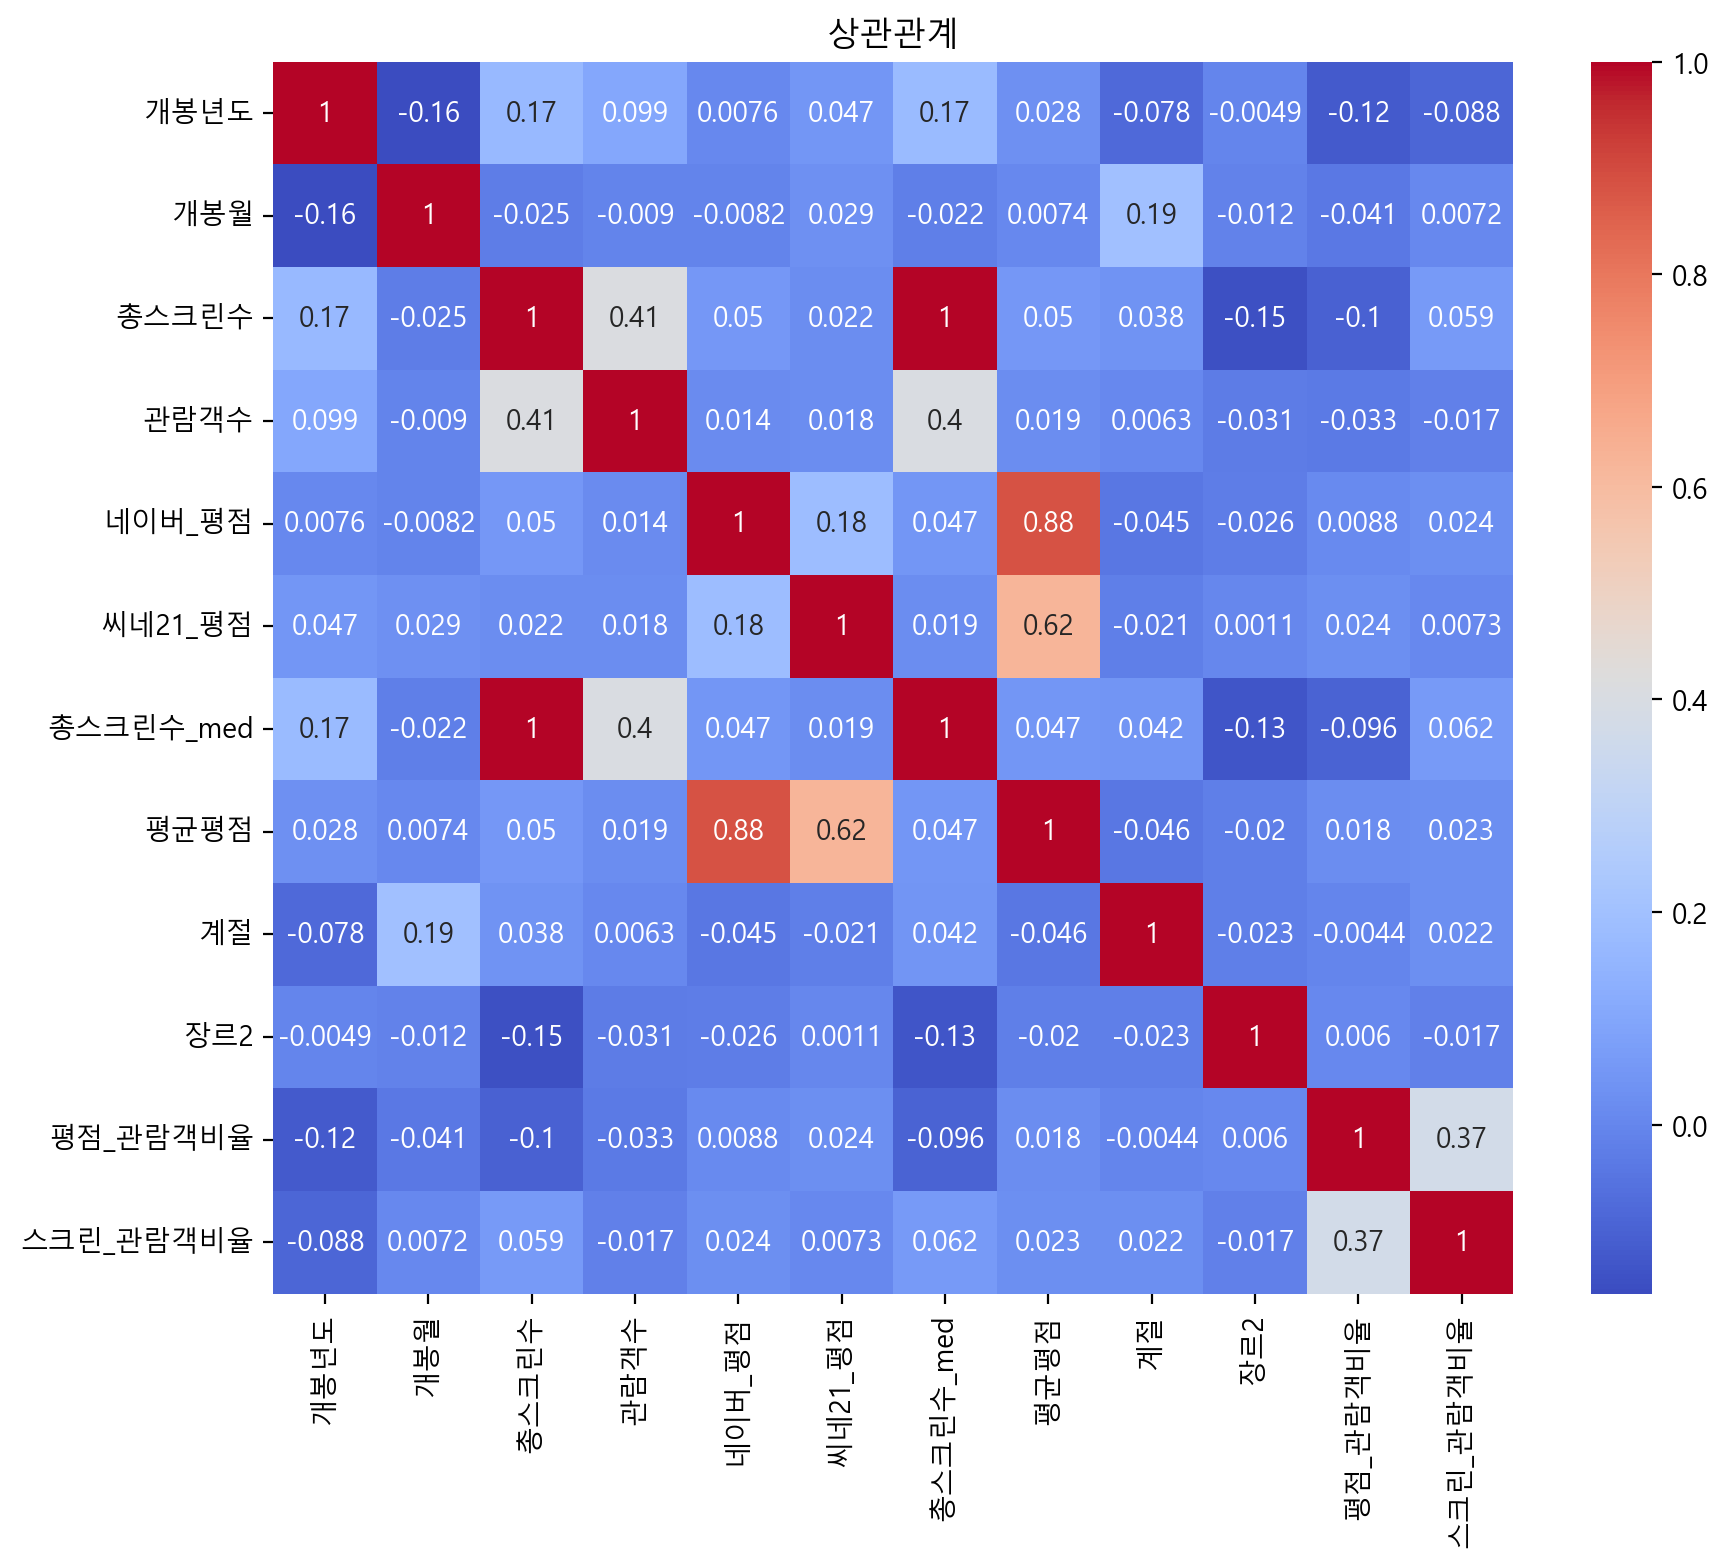

In [399]:
corr = movies_mean.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("상관관계")
plt.show()

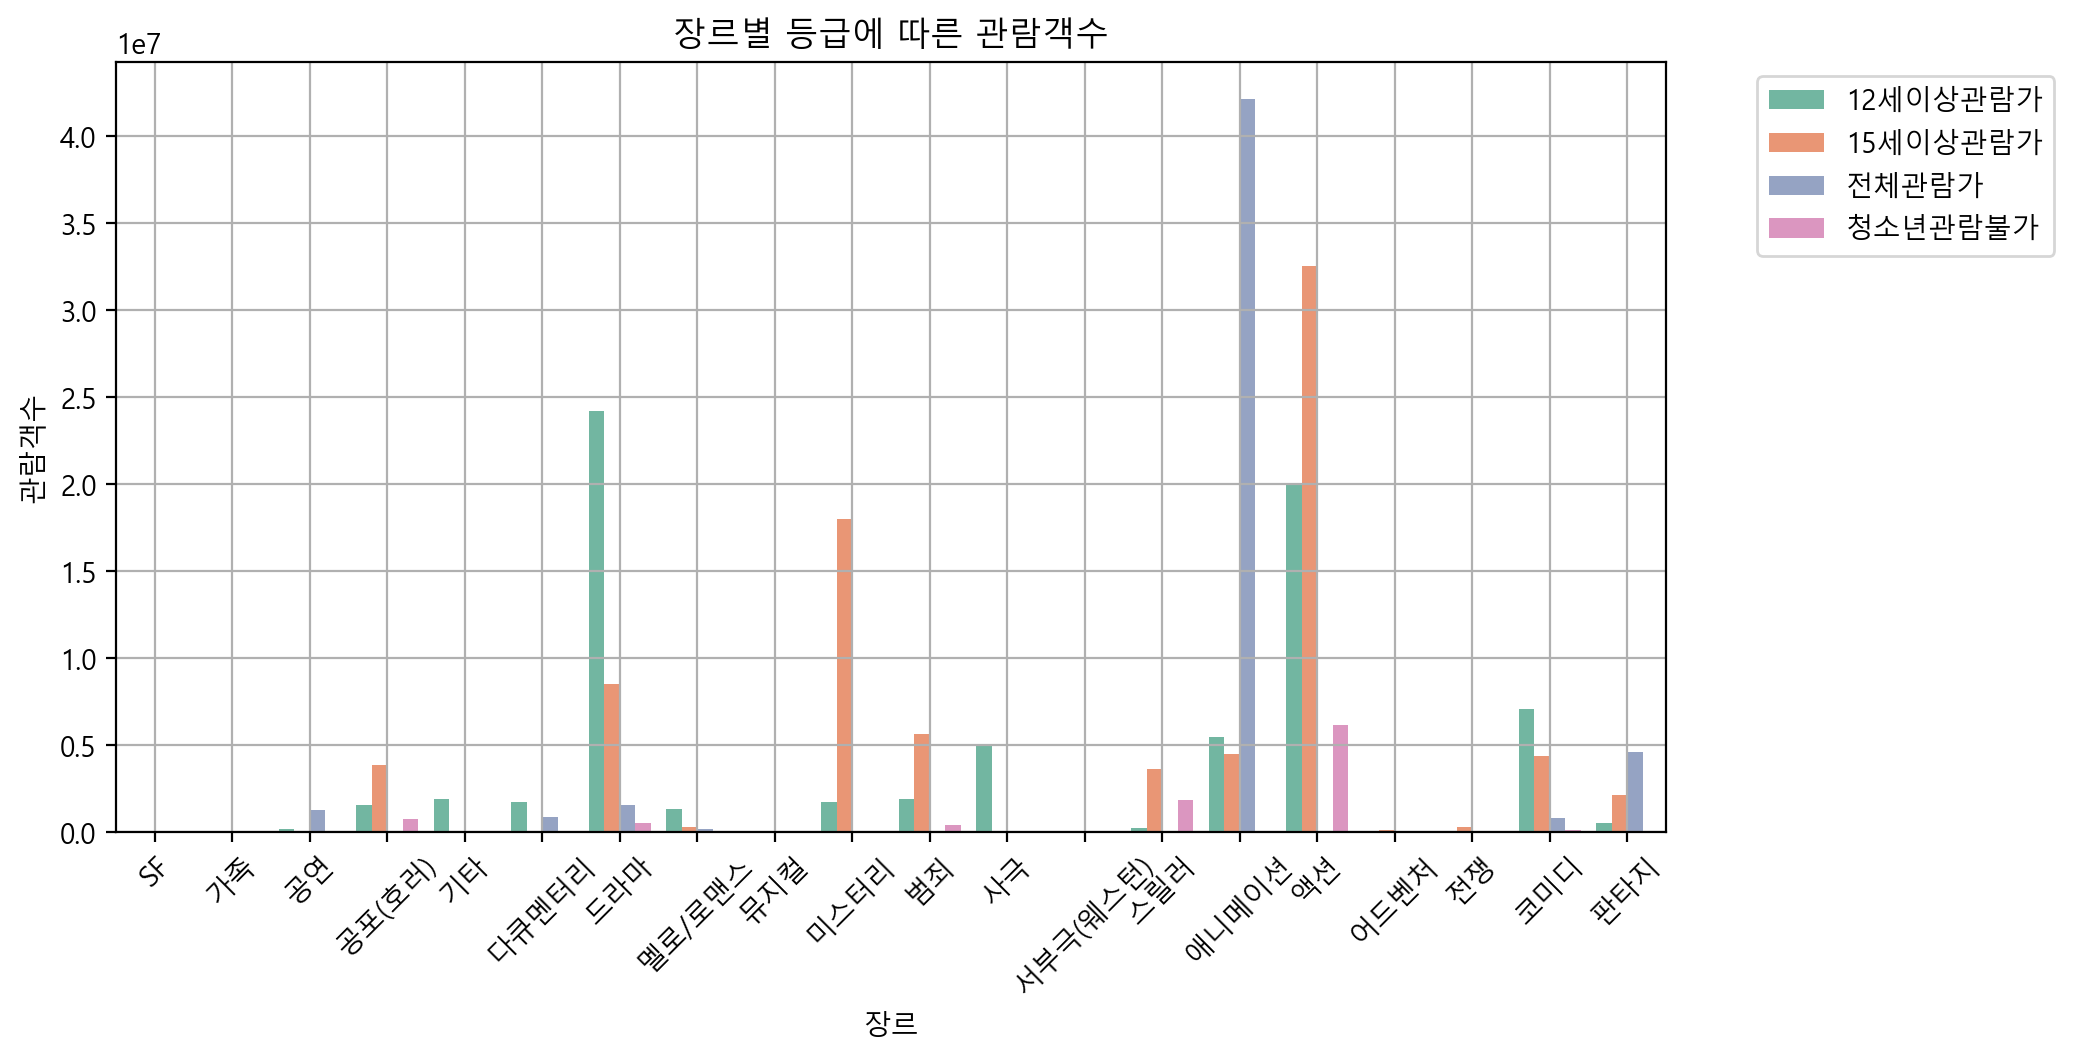

In [116]:
plt.figure(figsize=(10, 5))
mog = movies_mean.groupby(['장르', '등급'])['관람객수'].sum().reset_index()
sns.barplot(data=mog, x='장르', y='관람객수', hue='등급', palette='Set2')
plt.title('장르별 등급에 따른 관람객수')
plt.xlabel('장르')
plt.ylabel('관람객수')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

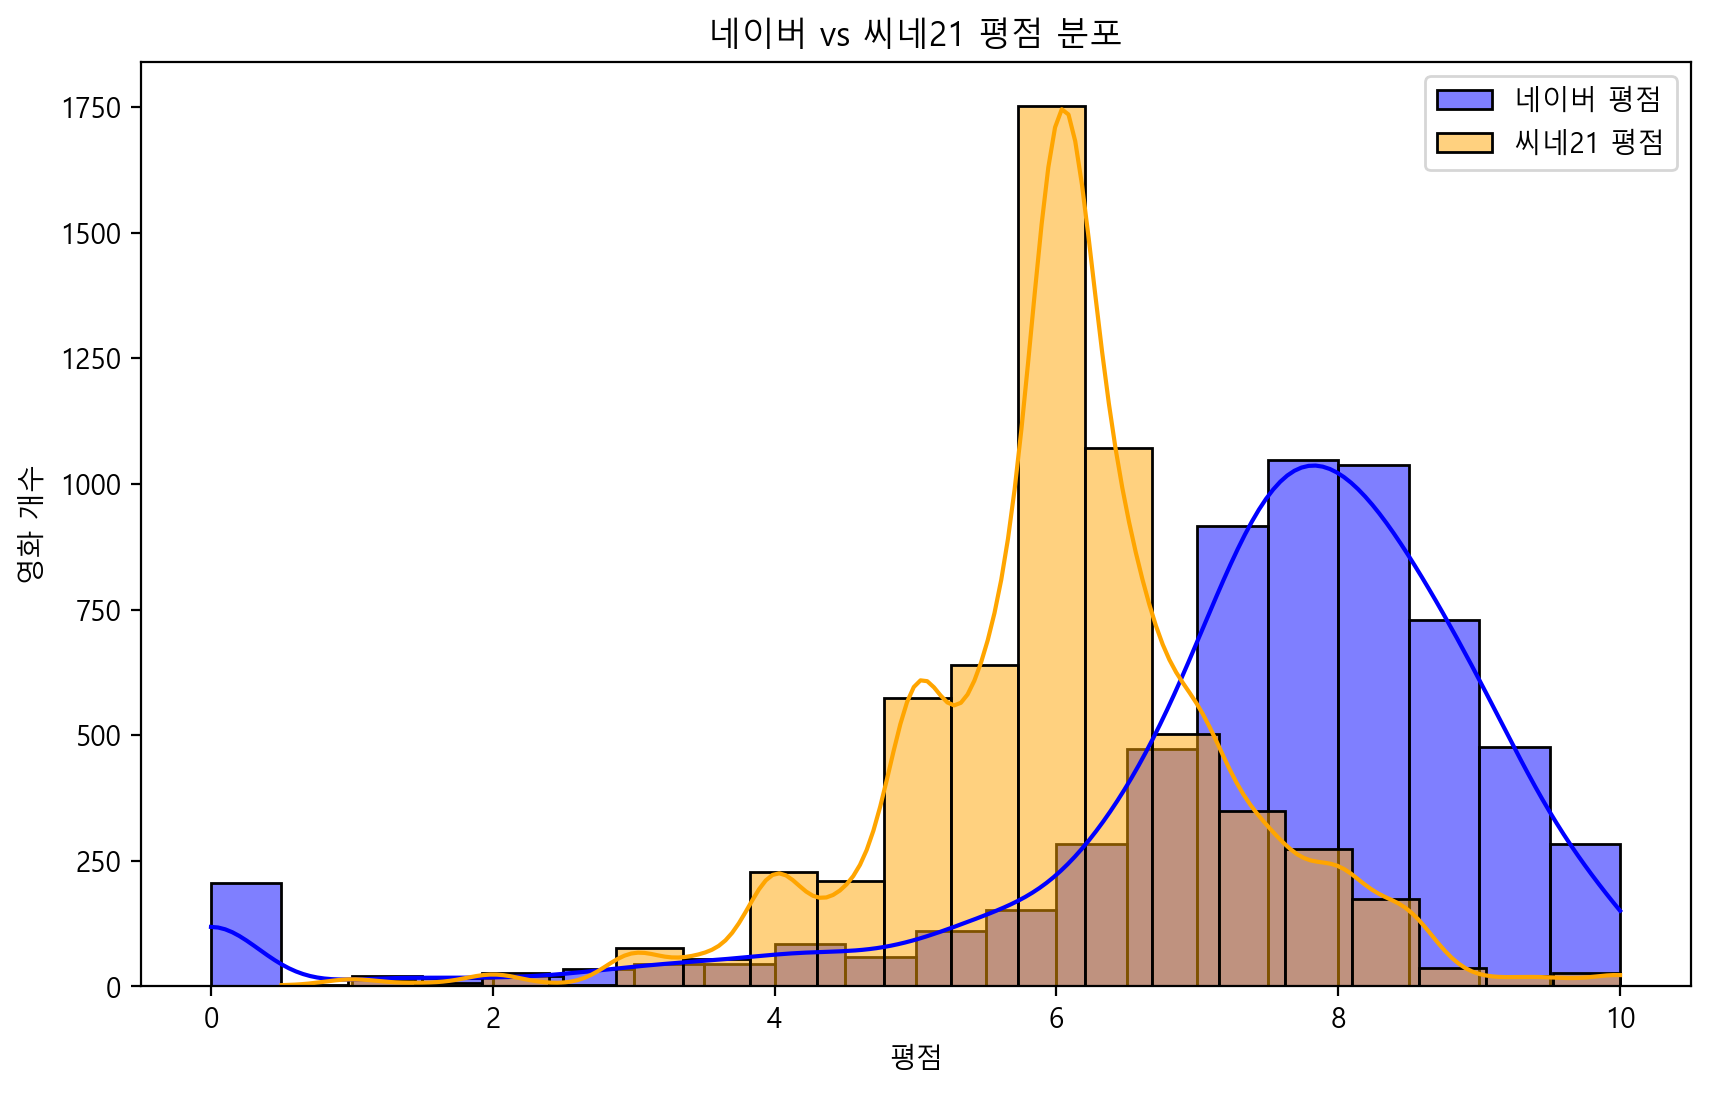

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(movies_mean['네이버_평점'], kde=True, color='blue', label='네이버 평점', bins=20)
sns.histplot(movies_mean['씨네21_평점'], kde=True, color='orange', label='씨네21 평점', bins=20)
plt.title('네이버 vs 씨네21 평점 분포')
plt.xlabel('평점')
plt.ylabel('영화 개수')
plt.legend()
plt.show()

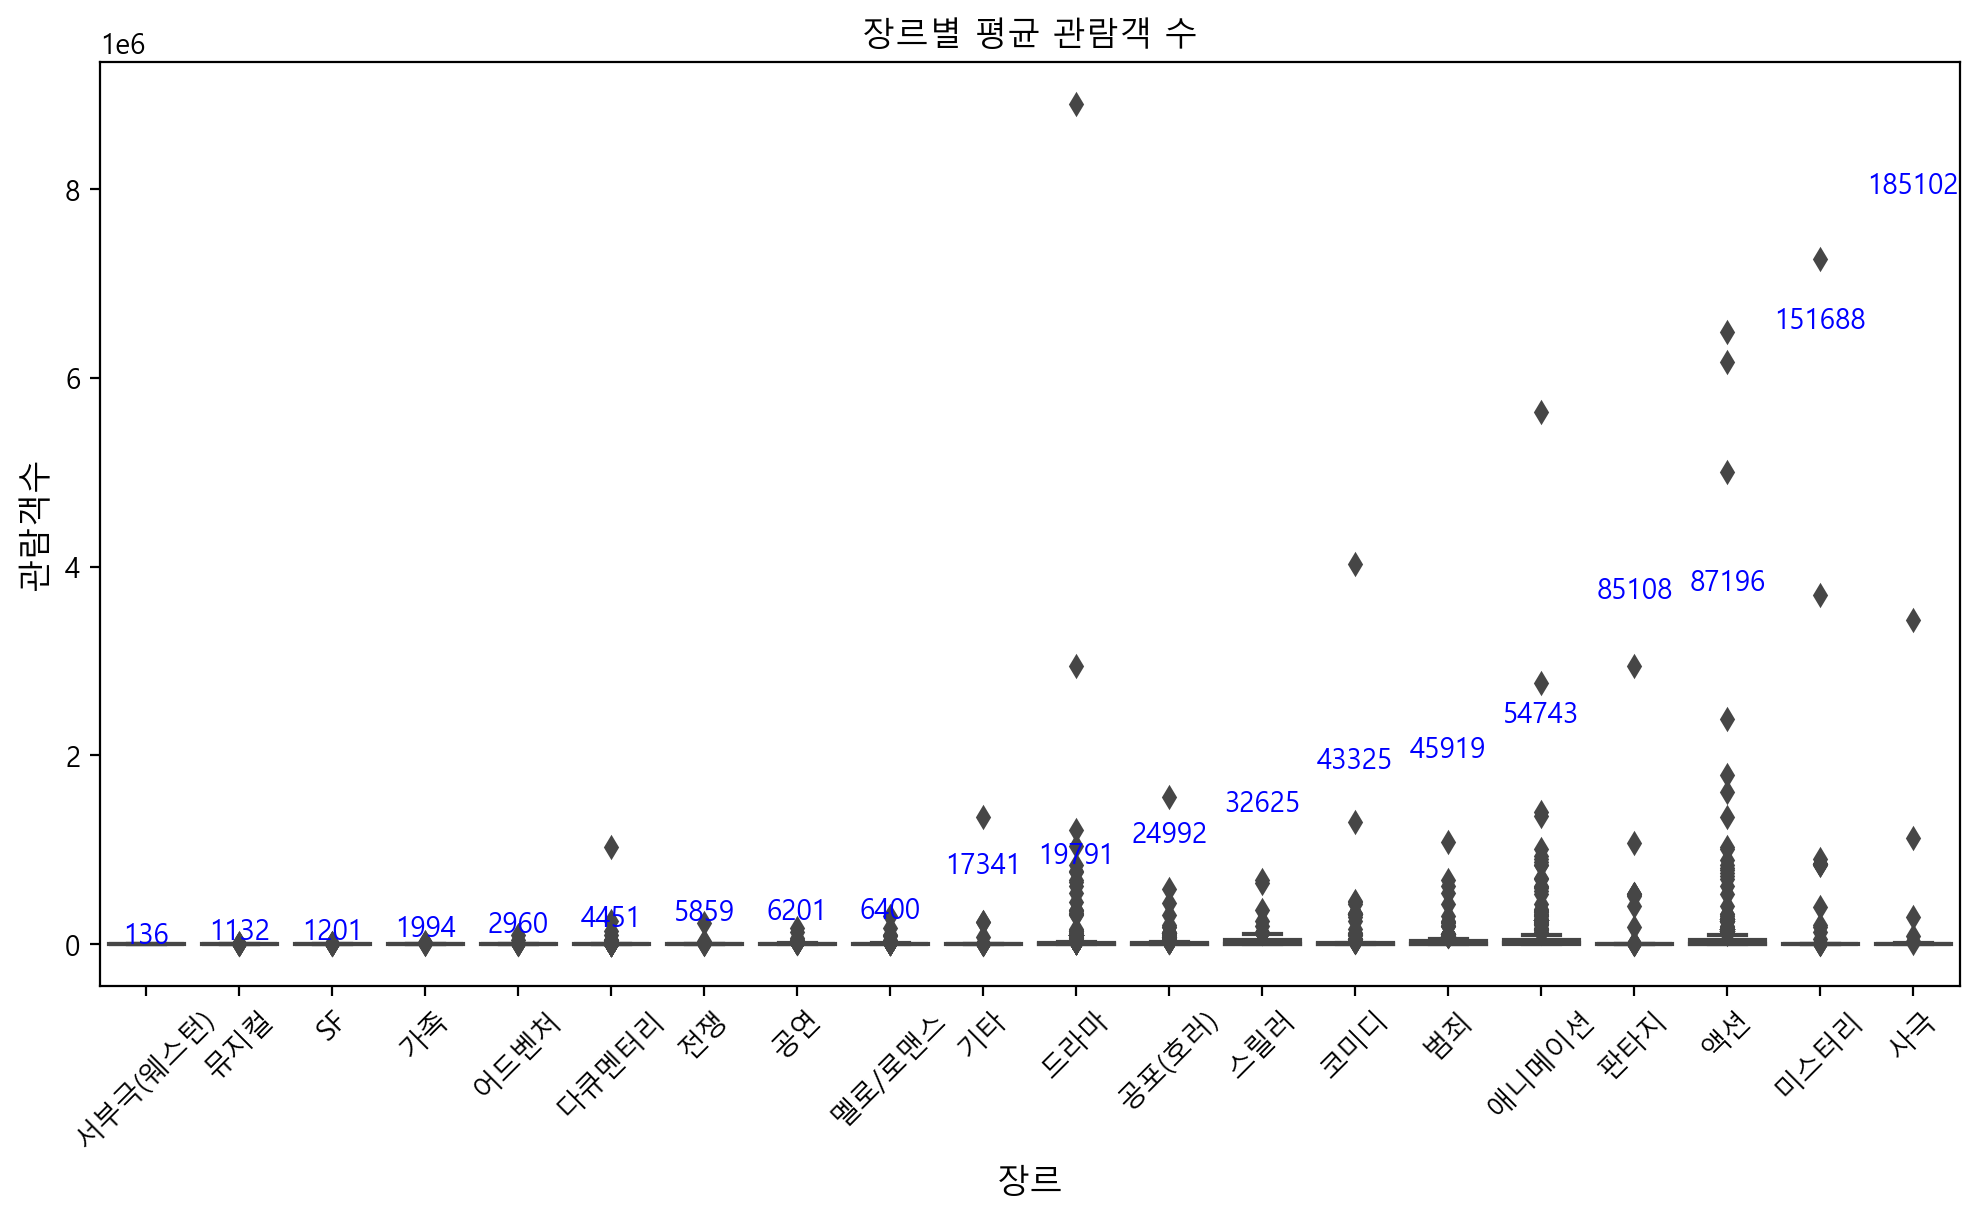

In [195]:
plt.figure(figsize=(12, 6))
sorted_data = movies_mean.groupby('장르')['관람객수'].mean().sort_values(ascending=True).reset_index()
ax = sns.boxplot(data=movies_mean, x='장르', y='관람객수', order=sorted_data['장르'])

for i, genre in enumerate(sorted_data['장르']):
    mean_value = movies_mean[movies_mean['장르'] == genre]['관람객수'].mean()
    ax.text(i, mean_value *43, f'{mean_value:.0f}', color='blue', ha='center')

plt.title('장르별 평균 관람객 수')
plt.xlabel('장르', fontsize=12)
plt.ylabel('관람객수', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.show()

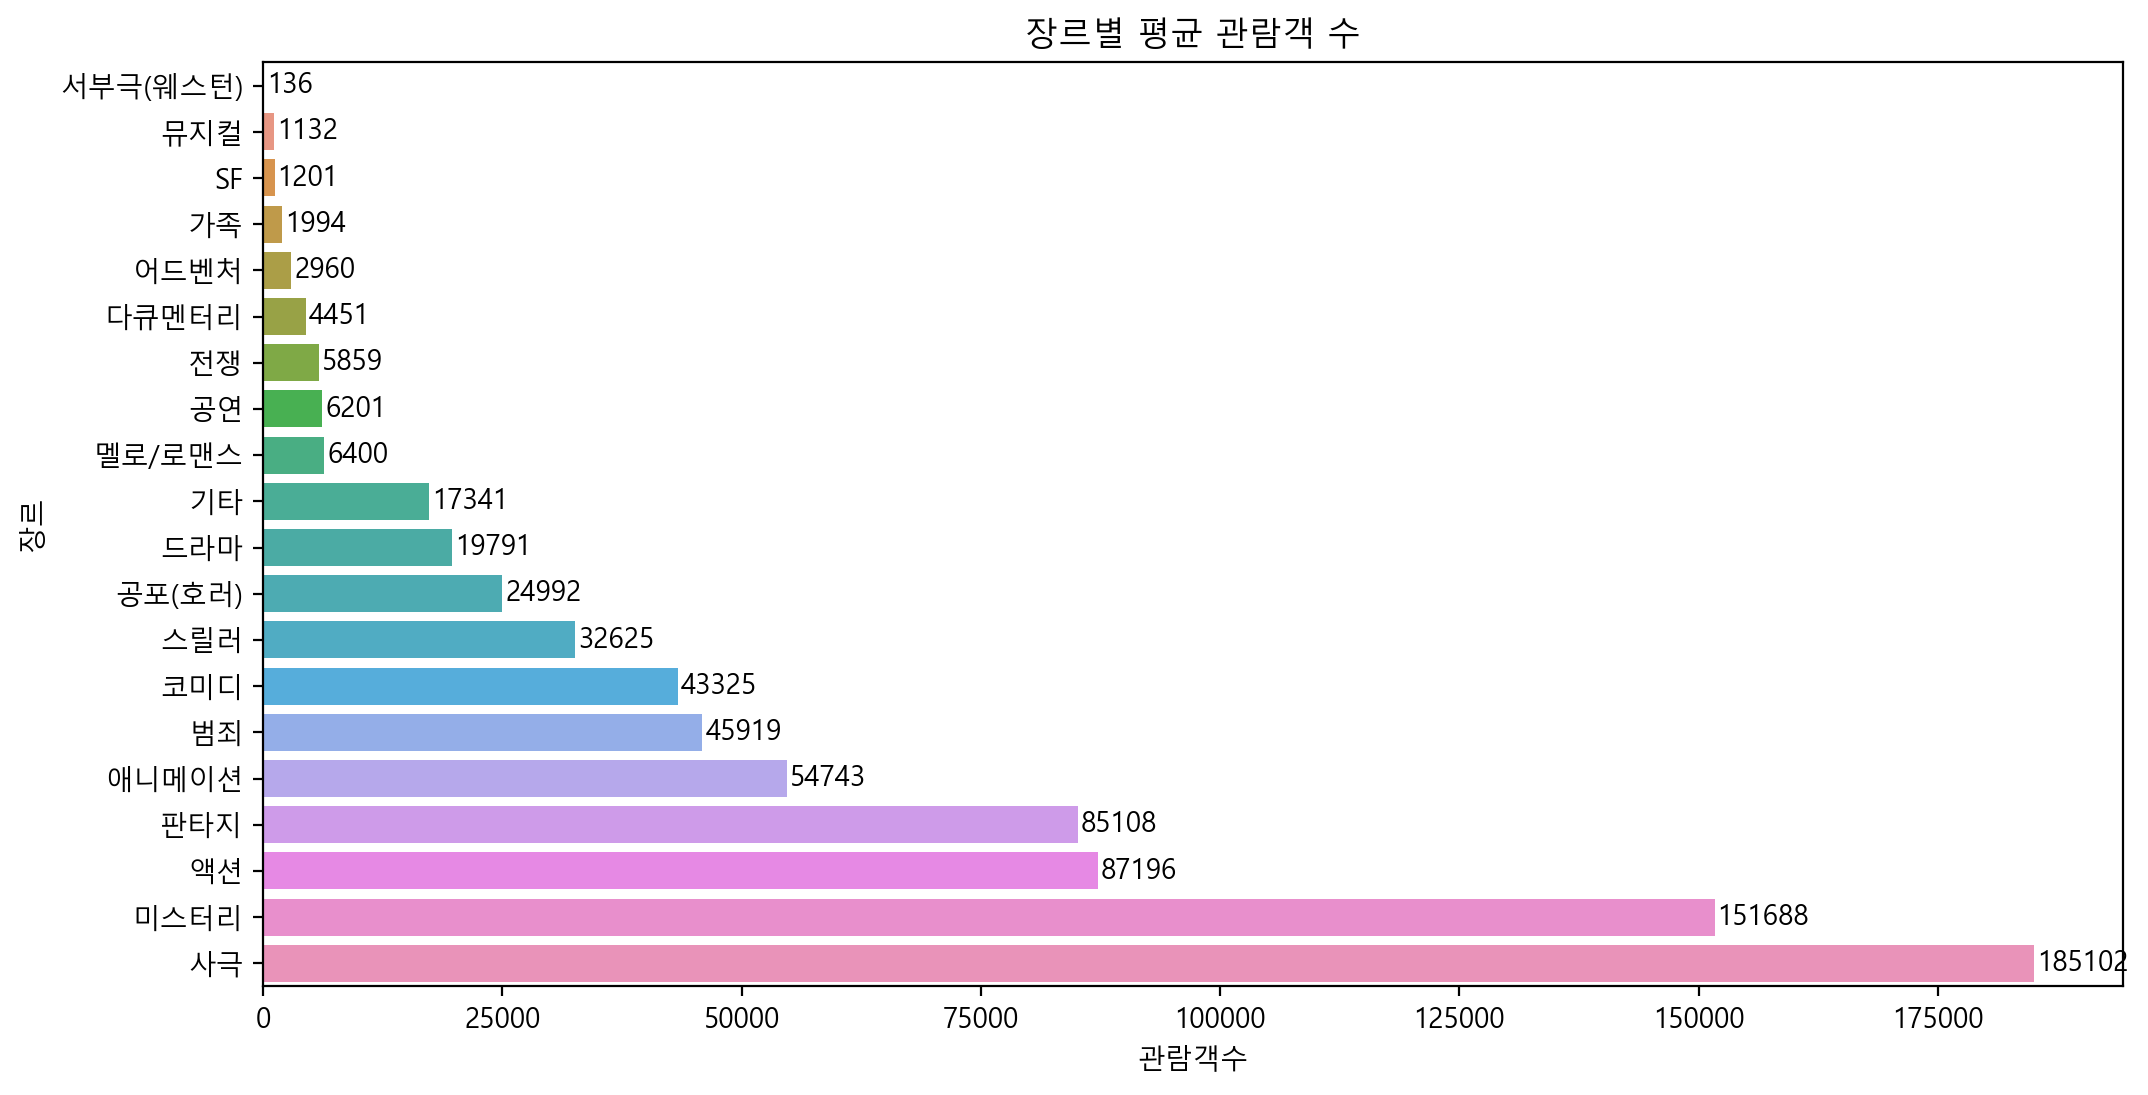

In [45]:
plt.figure(figsize=(12, 6))
sorted_data = movies_mean.groupby('장르')['관람객수'].mean().sort_values(ascending=True).reset_index()
ax = sns.barplot(data=sorted_data, x='관람객수', y='장르', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', padding=1)
plt.title('장르별 평균 관람객 수')
plt.show()

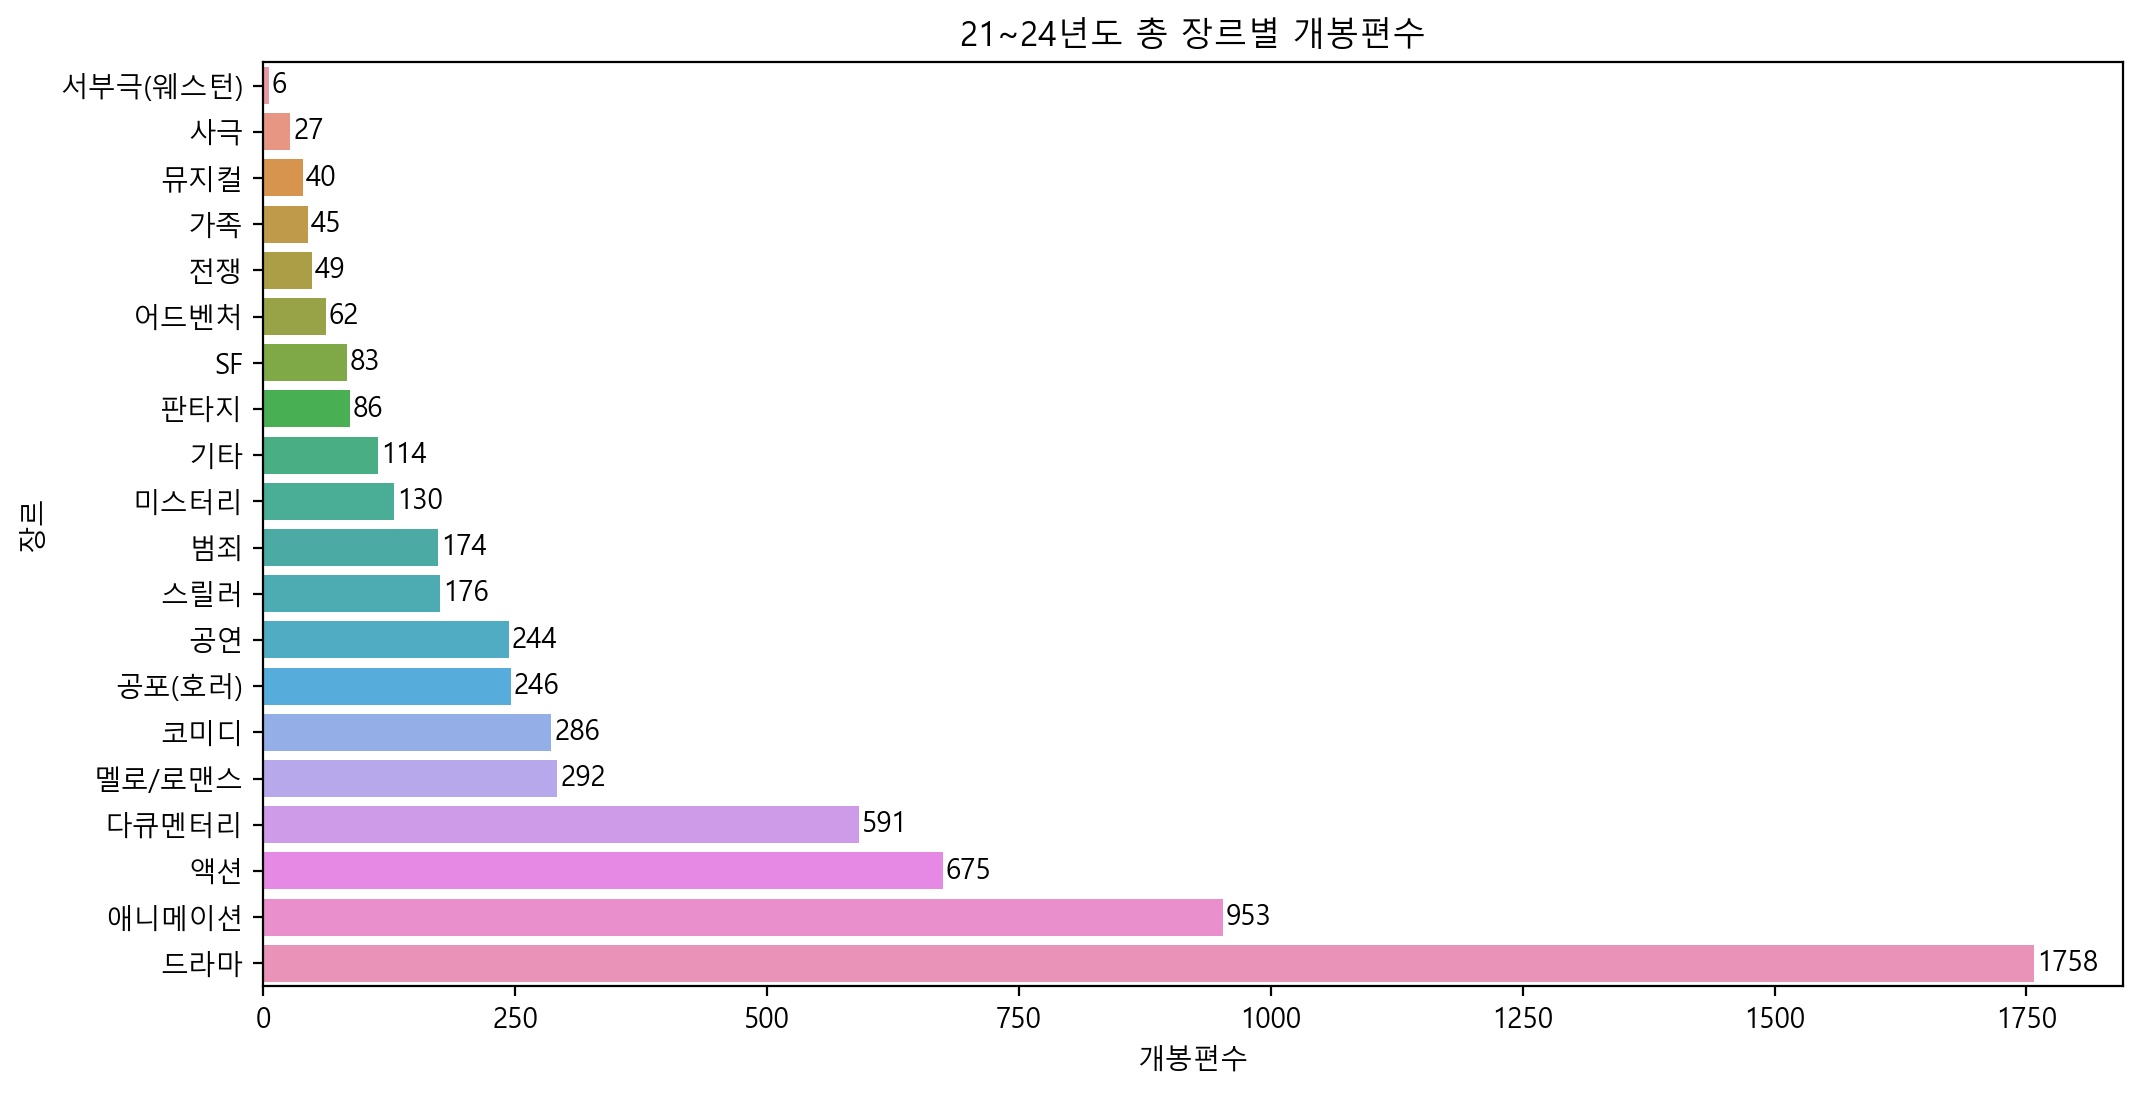

In [104]:
plt.figure(figsize=(12, 6))
sorted_data = movies_mean.groupby('장르')['개봉월'].count().sort_values(ascending=True).reset_index()
ax = sns.barplot(data=sorted_data, x='개봉월', y='장르', errorbar=None)
for i in ax.containers:
    ax.bar_label(i, fmt='%.0f', padding=1)
plt.title('21~24년도 총 장르별 개봉편수')
plt.xlabel('개봉편수')
plt.show()

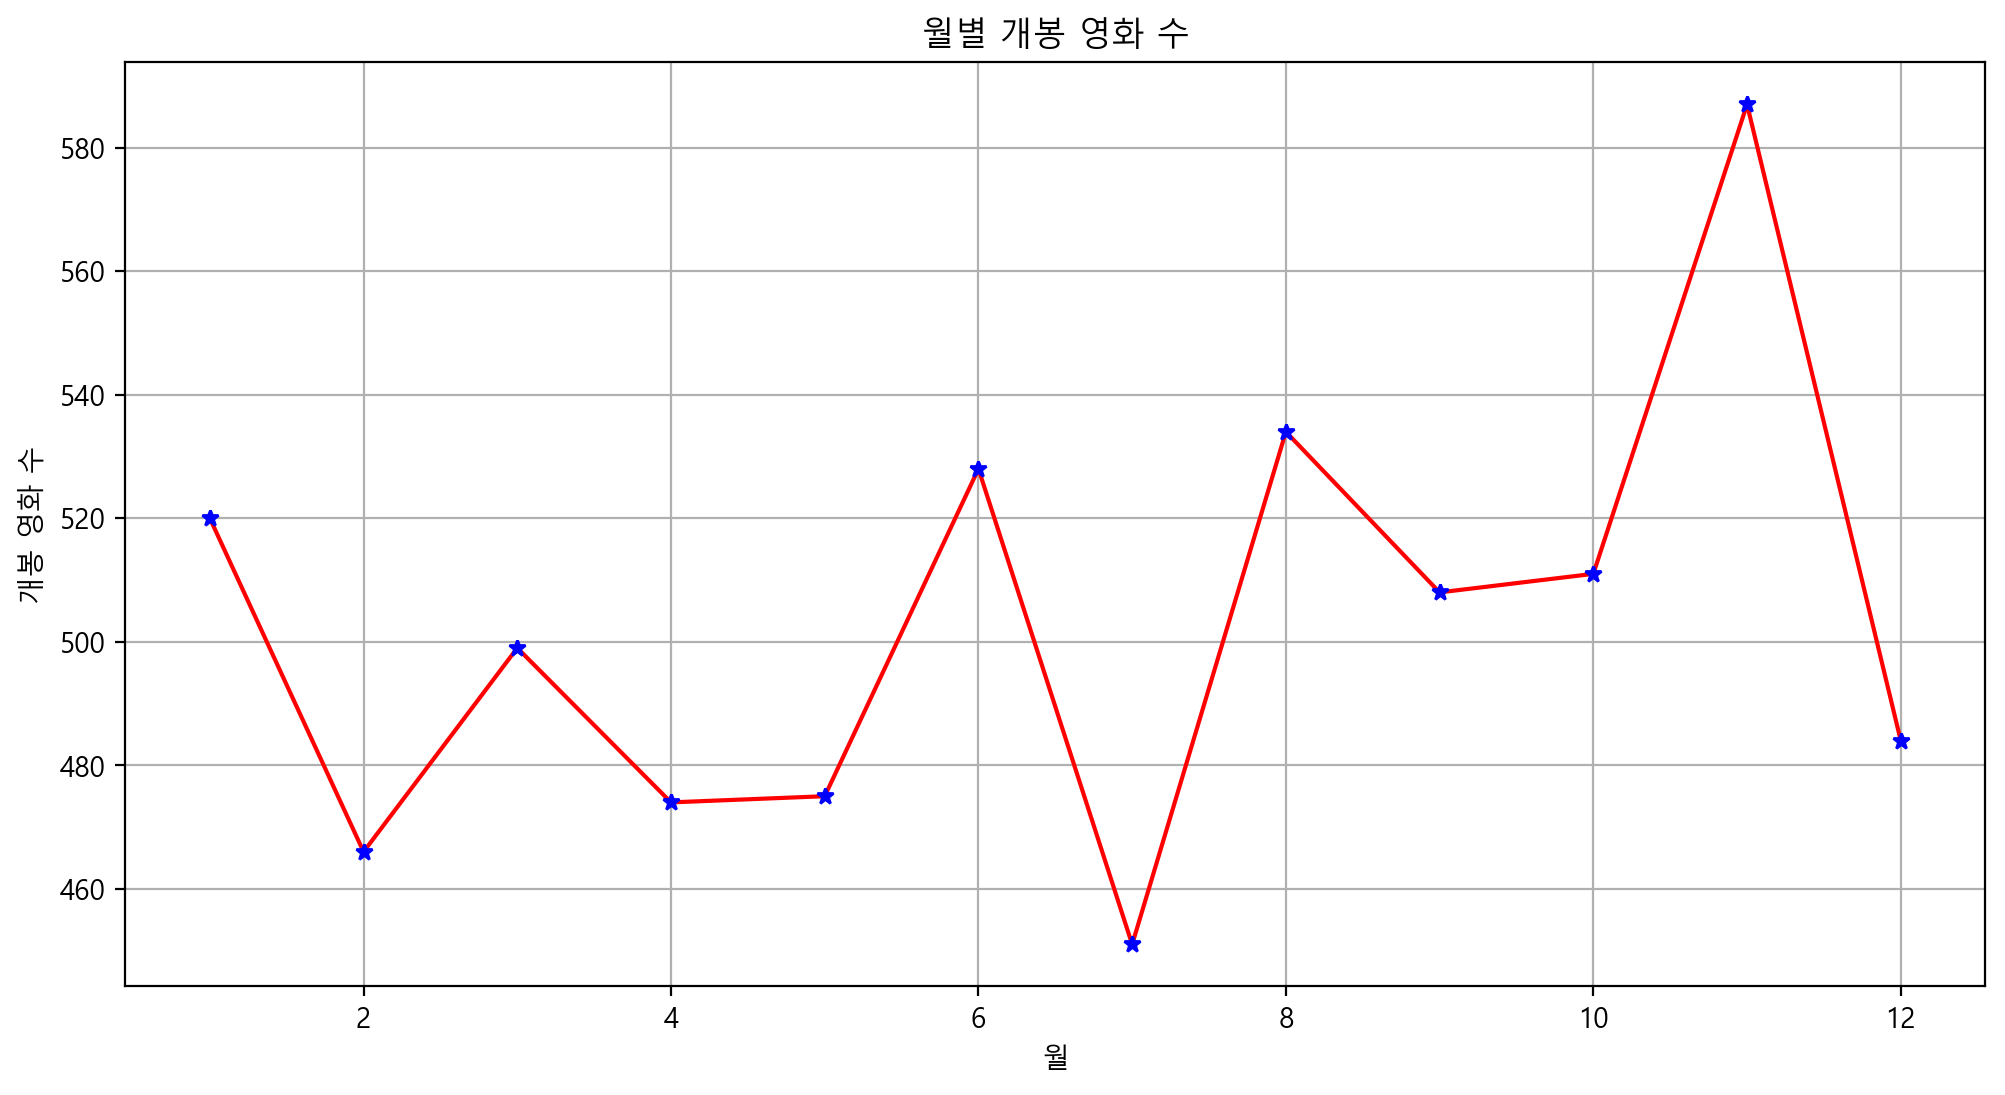

In [105]:
plt.figure(figsize=(12, 6))
plt.rc('font', family='Malgun Gothic')
ax = movies_mean.groupby('개봉월')['영화제목'].count().plot(kind='line', marker='*', markerfacecolor='blue', markeredgecolor='blue', color='red')
plt.title('월별 개봉 영화 수')
plt.xlabel('월')
plt.ylabel('개봉 영화 수')
plt.grid(True)
plt.show()

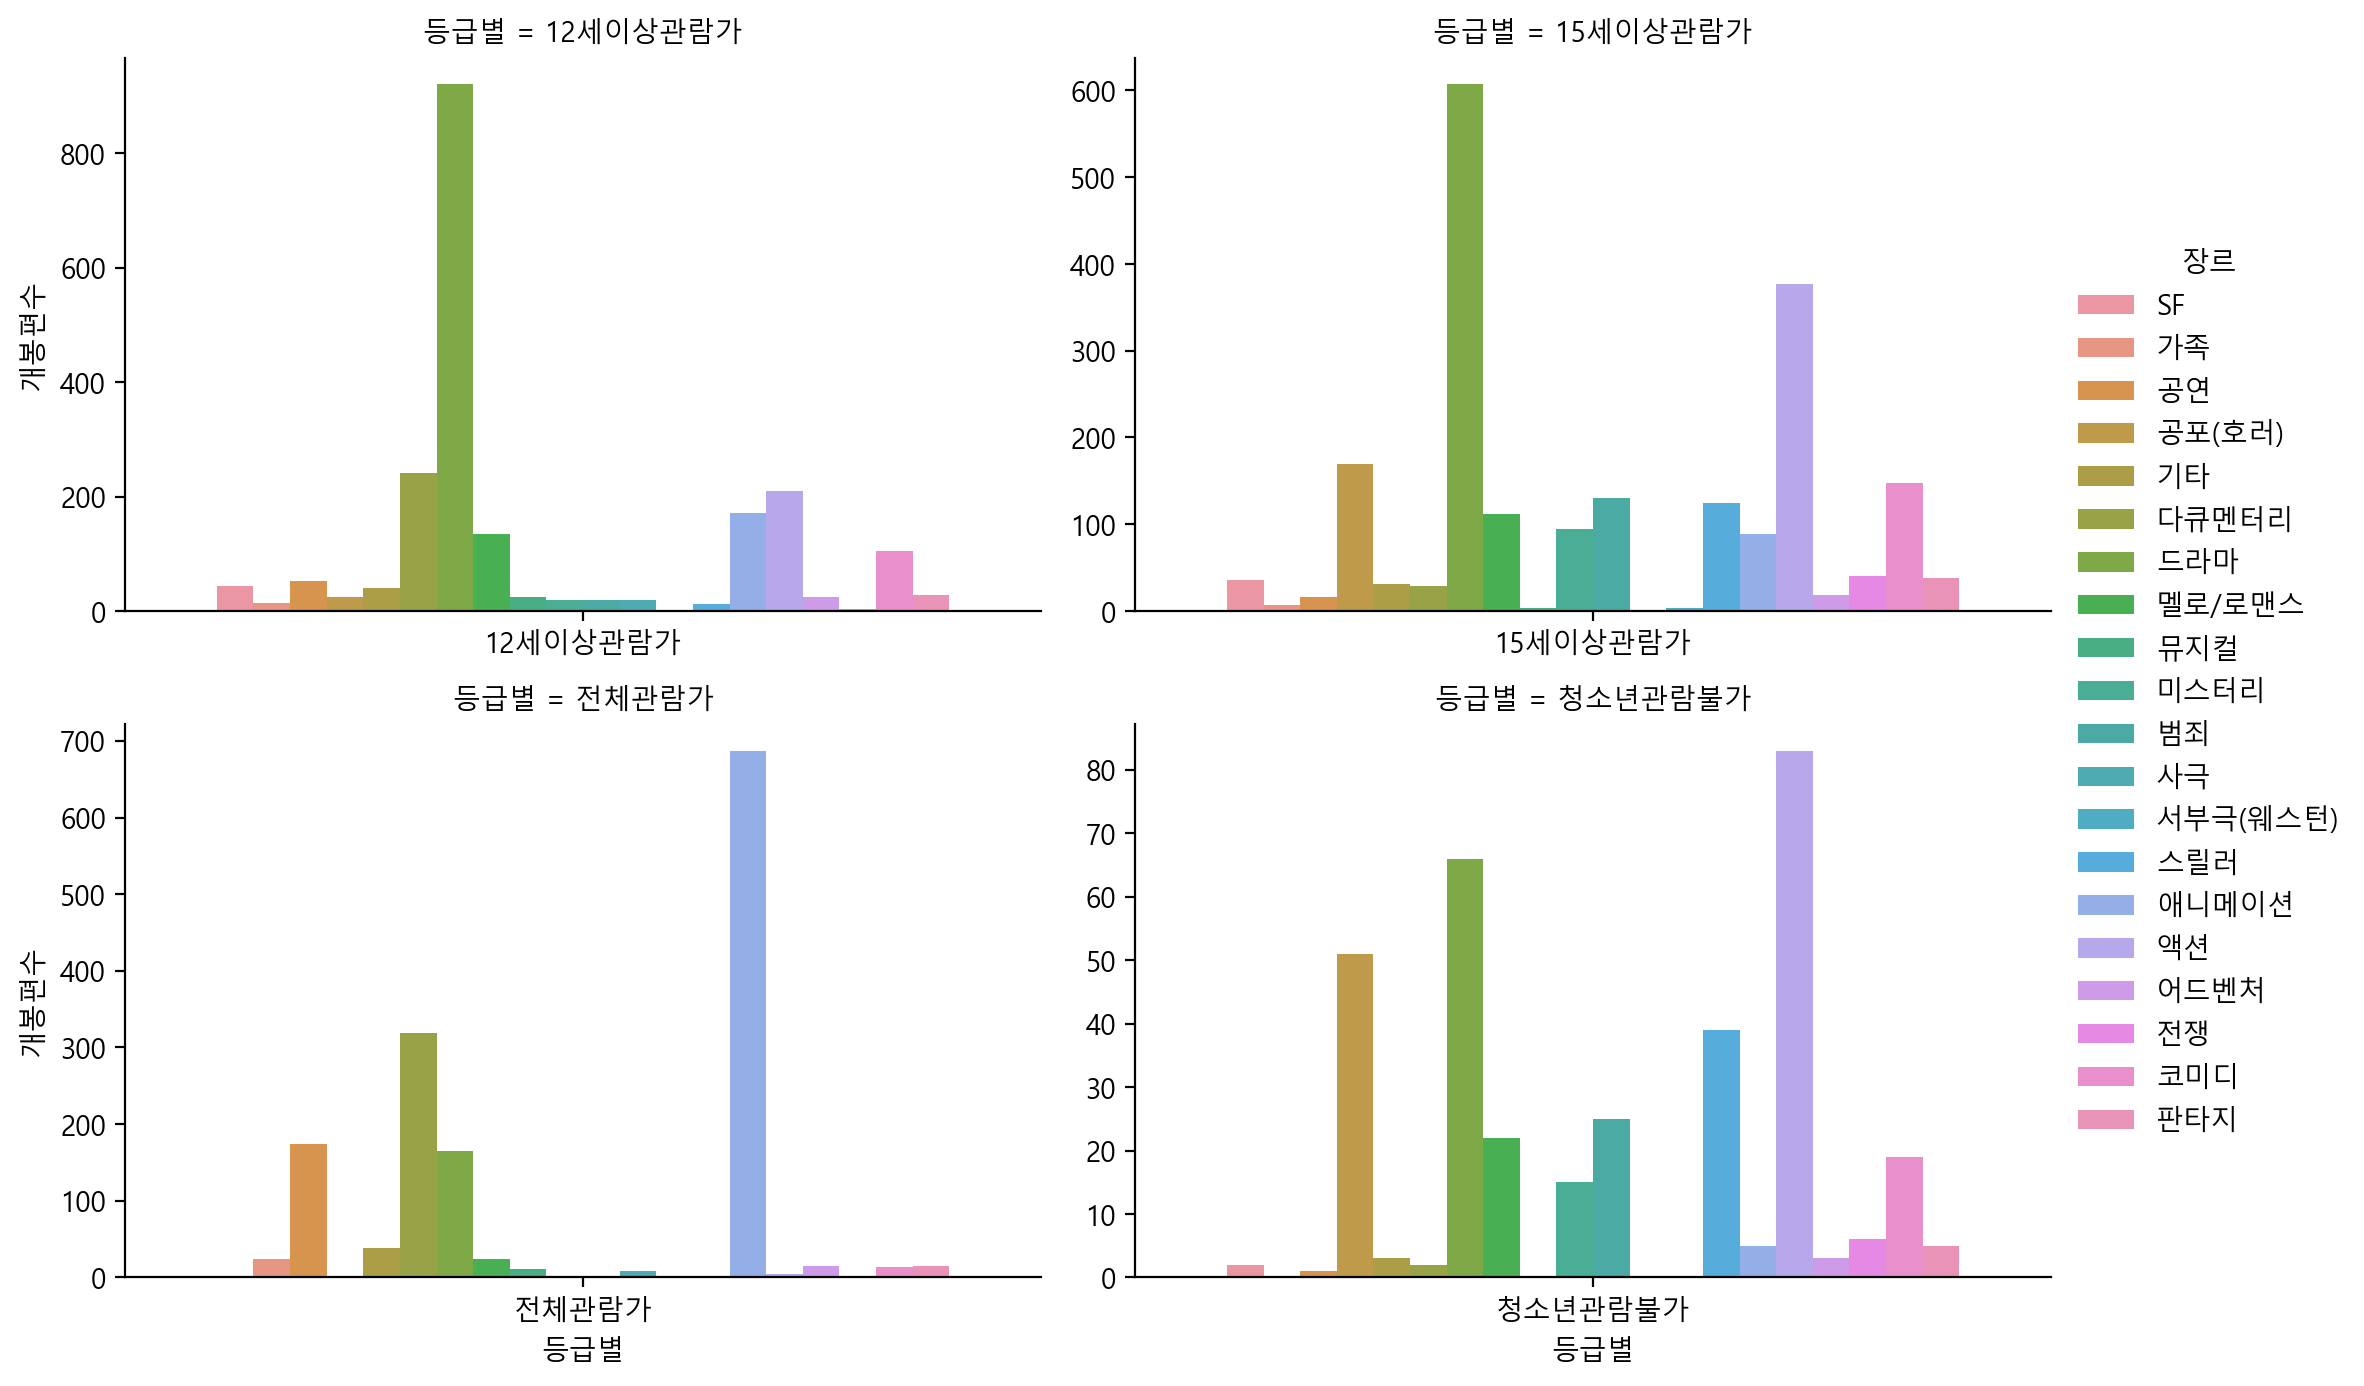

In [152]:
movie_grade = movies_mean.groupby(['장르','등급'])[['개봉월']].count().reset_index()
movie_grade = movie_grade.rename(columns={'장르':'장르',
                    '등급':'등급별',
                    '개봉월':'개봉편수'})
sns.catplot(data=movie_grade, 
            x='등급별', 
            y='개봉편수', 
            hue='장르', 
            kind='bar',
            col='등급별',
            sharey=False,
            sharex=False,
            height=3.5,
            aspect=1.5,
            col_wrap=2)
plt.show()

# DNN (계절예측)

In [5]:
def season(month):
    if 3 <= month <= 5:
        return '1'
    elif 6 <= month <= 8:
        return '2'
    elif 9 <= month <= 11:
        return '3'
    else :
        return '4'

In [6]:
movies_mean['계절'] = movies_mean['개봉월'].apply(season)
movies_mean.sample(3)

,영화제목,유통회사명,개봉년도,개봉월,총스크린수,관람객수,장르,등급,네이버_평점,씨네21_평점,총스크린수_med,평균평점,계절
5097,죽음의 땅,(주)라온컴퍼니플러스,2022,4,1.0,1.0,스릴러,15세이상관람가,8.14,6.00,1.0,7.07,1
3812,언더더씨: 마법 산호초를 찾아서,(주)팝엔터테인먼트,2024,6,215.0,19087.0,애니메이션,전체관람가,8.22,2.00,215.0,5.11,2
3768,별처럼 빛나는 너에게 더무비-일섬일섬량성성,워터홀컴퍼니(주),2024,5,191.0,662.0,판타지,12세이상관람가,6.97,7.25,191.0,7.11,1


In [7]:
# 장르2를 만들어 번호와 이름이 같이 출력할수있게 딕셔너리로 변경
movies_genre = {movie:idx   for idx, movie in enumerate(movies_mean['장르'].unique())}
# movies_genre
movies_mean['장르2'] = movies_mean['장르'].map(movies_genre)
print(movies_mean[['장르', '장르2']].head())

      장르  장르2
0  애니메이션    0
1  애니메이션    0
2     액션    1
3    드라마    2
4  애니메이션    0


In [8]:
# 계절 type변경
movies_mean['계절'] = movies_mean['계절'].astype(np.float16)

In [122]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_mean['계절_le'] = le.fit_transform(movies_mean['계절'])
movies_mean['등급_le'] = le.fit_transform(movies_mean['등급'])
movies_mean['관람객수_le'] = le.fit_transform(movies_mean['관람객수'])

x = movies_mean[['장르2','총스크린수_med','관람객수_le', '등급_le']]
y = movies_mean['계절_le']

In [123]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4829, 4), (4829,), (1208, 4), (1208,))

In [124]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [125]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(X_train.shape[1],)), # 입력데이터의 colunm 수
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(movies_mean['계절_le'].unique()), activation='softmax')  # 장르의 개수만큼 출력층 생성
])

In [126]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_sea-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               

hist = model.fit(X_train, y_train, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = earlyStopping
                )

Epoch 1/500
121/121 [==============================] - 1s 7ms/step - loss: 1.3876 - accuracy: 0.2638 - val_loss: 1.3829 - val_accuracy: 0.2764
Epoch 2/500
121/121 [==============================] - 1s 5ms/step - loss: 1.3831 - accuracy: 0.2710 - val_loss: 1.3817 - val_accuracy: 0.2774
Epoch 3/500
121/121 [==============================] - 0s 4ms/step - loss: 1.3798 - accuracy: 0.2904 - val_loss: 1.3859 - val_accuracy: 0.2588
Epoch 4/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3778 - accuracy: 0.2938 - val_loss: 1.3773 - val_accuracy: 0.2919
Epoch 5/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3788 - accuracy: 0.2881 - val_loss: 1.3797 - val_accuracy: 0.2950
Epoch 6/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3753 - accuracy: 0.2928 - val_loss: 1.3755 - val_accuracy: 0.2981
Epoch 7/500
121/121 [==============================] - 0s 4ms/step - loss: 1.3751 - accuracy: 0.3068 - val_loss: 1.3735 - val_accuracy: 0.2888

Epoch 58/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3023 - accuracy: 0.3759 - val_loss: 1.3486 - val_accuracy: 0.3406
Epoch 59/500
121/121 [==============================] - 0s 4ms/step - loss: 1.2935 - accuracy: 0.3922 - val_loss: 1.3449 - val_accuracy: 0.3458
Epoch 60/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2977 - accuracy: 0.3803 - val_loss: 1.3578 - val_accuracy: 0.3199
Epoch 61/500
121/121 [==============================] - 0s 4ms/step - loss: 1.2979 - accuracy: 0.3787 - val_loss: 1.3513 - val_accuracy: 0.3323
Epoch 62/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2942 - accuracy: 0.3818 - val_loss: 1.3517 - val_accuracy: 0.3364
Epoch 63/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2934 - accuracy: 0.3888 - val_loss: 1.3512 - val_accuracy: 0.3271
Epoch 64/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2863 - accuracy: 0.3862 - val_loss: 1.3470 - val_accuracy:

Epoch 115/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2363 - accuracy: 0.4194 - val_loss: 1.3597 - val_accuracy: 0.3499
Epoch 116/500
121/121 [==============================] - 0s 4ms/step - loss: 1.2281 - accuracy: 0.4225 - val_loss: 1.3603 - val_accuracy: 0.3551
Epoch 117/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2315 - accuracy: 0.4232 - val_loss: 1.3585 - val_accuracy: 0.3665
Epoch 118/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2324 - accuracy: 0.4173 - val_loss: 1.3587 - val_accuracy: 0.3696
Epoch 119/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2265 - accuracy: 0.4284 - val_loss: 1.3717 - val_accuracy: 0.3623
Epoch 120/500
121/121 [==============================] - 0s 4ms/step - loss: 1.2295 - accuracy: 0.4253 - val_loss: 1.3588 - val_accuracy: 0.3530
Epoch 121/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2353 - accuracy: 0.4165 - val_loss: 1.3663 - val_ac

In [127]:
# 모델 평가하기 
loss, accuracy = model.evaluate(X_test, y_test)
print(accuracy*100, '%')

38/38 [==============================] - 0s 2ms/step - loss: 1.3132 - accuracy: 0.3684
36.83774769306183 %


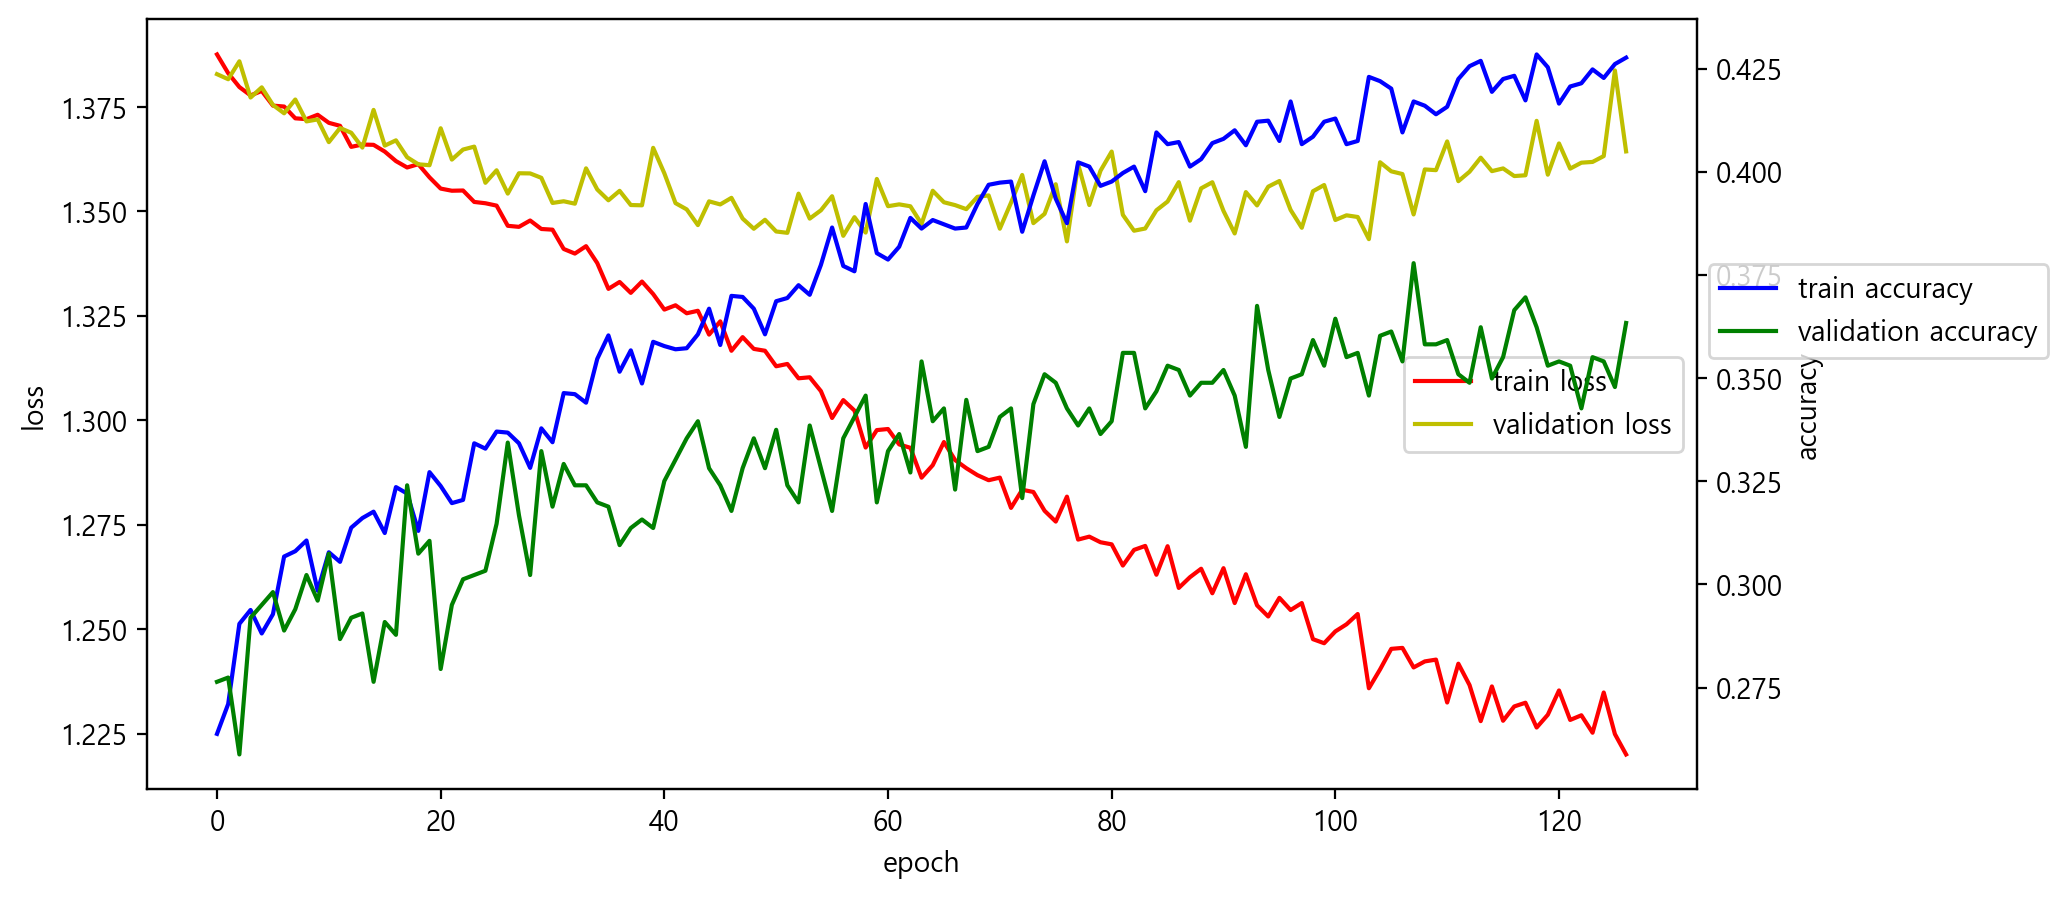

In [128]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

# DNN (관객수 예측)

In [154]:
movies_mean['관객수_등급'] = pd.qcut(
    movies_mean['관람객수'], 
    q= 5, 
    labels=range(1, 6)  # 구간을 숫자로 변환
)
print(movies_mean[['관객수_등급','관람객수']])

     관객수_등급      관람객수
0         5  875001.0
1         5  206309.0
2         5  155562.0
3         5   42290.0
4         5   38131.0
...     ...       ...
6032      1       3.0
6033      1       2.0
6034      1       2.0
6035      1       1.0
6036      1       1.0

[6037 rows x 2 columns]


In [155]:
# 관객수_순위 타입변환
movies_mean['관객수_등급'] = movies_mean['관객수_등급'].astype(int)
print(movies_mean[['관객수_등급','관람객수']].sample(5))

      관객수_등급          관람객수
2825       5  26575.857422
4418       1     19.000000
2682       4   6496.333496
5086       1     16.000000
4132       4   5849.000000


In [156]:
# 라벨인코딩 
le = LabelEncoder()
movies_mean['계절_le'] = le.fit_transform(movies_mean['계절'])
movies_mean['등급_le'] = le.fit_transform(movies_mean['등급'])

# 데이터 준비 
x = movies_mean[['장르2', '계절_le','총스크린수_med', '등급_le']]
y = movies_mean['관객수_등급']
# y 원핫인코딩
y = to_categorical(y) # y 원핫인코딩

In [157]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4829, 4), (4829, 6), (1208, 4), (1208, 6))

In [158]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [1]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # 입력
    Dense(128, activation='relu'),# 은닉층
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'), 
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(6, activation='softmax') # 출력층
])
model.summry()

NameError: name 'Sequential' is not defined

In [160]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',  # 원-핫 인코딩된 y_train 사용 시
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)
# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_aud-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          # 저장경로
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               # 저장 여부 로그 출력 (0:출력 안 함)

hist = model.fit(X_train, y_train, 
                 epochs=500, 
                 validation_split=0.2, 
                 callbacks=[checkpoint, earlyStopping])

Epoch 1/500
121/121 [==============================] - 1s 8ms/step - loss: 1.5988 - accuracy: 0.2899 - val_loss: 1.5356 - val_accuracy: 0.2878
Epoch 2/500
121/121 [==============================] - 1s 5ms/step - loss: 1.5359 - accuracy: 0.3117 - val_loss: 1.5239 - val_accuracy: 0.2940
Epoch 3/500
121/121 [==============================] - 1s 5ms/step - loss: 1.5129 - accuracy: 0.3171 - val_loss: 1.4894 - val_accuracy: 0.3137
Epoch 4/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4998 - accuracy: 0.3288 - val_loss: 1.4815 - val_accuracy: 0.3240
Epoch 5/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4941 - accuracy: 0.3301 - val_loss: 1.4782 - val_accuracy: 0.3344
Epoch 6/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4810 - accuracy: 0.3479 - val_loss: 1.4943 - val_accuracy: 0.3540
Epoch 7/500
121/121 [==============================] - 1s 5ms/step - loss: 1.4740 - accuracy: 0.3546 - val_loss: 1.4529 - val_accuracy: 0.3364

Epoch 58/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3109 - accuracy: 0.4432 - val_loss: 1.3899 - val_accuracy: 0.3996
Epoch 59/500
121/121 [==============================] - 1s 5ms/step - loss: 1.3096 - accuracy: 0.4406 - val_loss: 1.3826 - val_accuracy: 0.4068
Epoch 60/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3008 - accuracy: 0.4359 - val_loss: 1.3864 - val_accuracy: 0.4017
Epoch 61/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3019 - accuracy: 0.4473 - val_loss: 1.3959 - val_accuracy: 0.4027
Epoch 62/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3171 - accuracy: 0.4401 - val_loss: 1.3871 - val_accuracy: 0.3996
Epoch 63/500
121/121 [==============================] - 1s 4ms/step - loss: 1.3094 - accuracy: 0.4390 - val_loss: 1.3855 - val_accuracy: 0.4006
Epoch 64/500
121/121 [==============================] - 1s 4ms/step - loss: 1.2983 - accuracy: 0.4520 - val_loss: 1.4064 - val_accuracy:

In [161]:
# 모델 평가하기
loss, accuracy = model.evaluate(X_test, y_test)
print(accuracy*100, '%')

38/38 [==============================] - 0s 2ms/step - loss: 1.3932 - accuracy: 0.4040
40.39735198020935 %


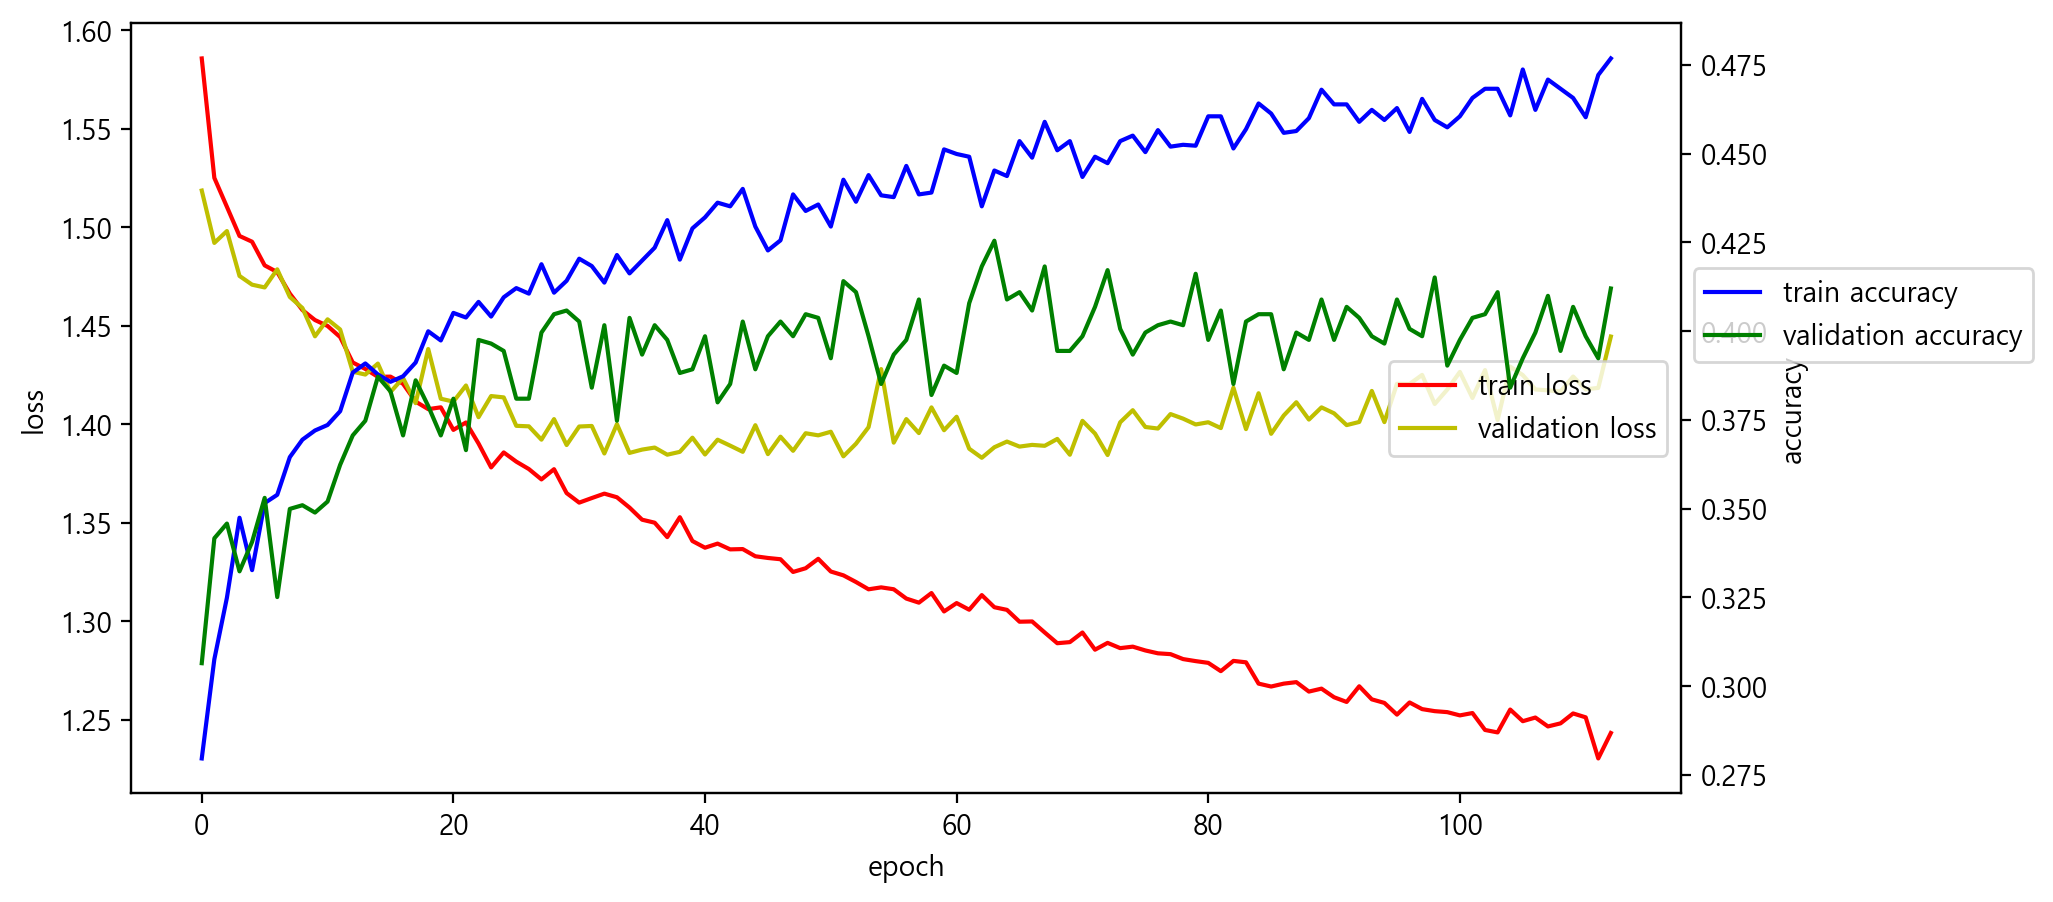

In [146]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

# SMOTE 데이터 증강 학습 (계절예측)

In [147]:
# 데이터 준비 (분류분석)
# 라벨인코딩 
le = LabelEncoder()
movies_mean['계절_le'] = le.fit_transform(movies_mean['계절'])
movies_mean['등급_le'] = le.fit_transform(movies_mean['등급'])
movies_mean['관람객수_le'] = le.fit_transform(movies_mean['관람객수'])

x = movies_mean[['장르2','총스크린수_med','관람객수_le', '등급_le']]
y = movies_mean['계절_le']

In [148]:
# 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=38)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4829, 4), (4829,), (1208, 4), (1208,))

In [149]:
# 데이터 증강
smote = SMOTE(random_state=38, k_neighbors=2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("비조정 SMOTE", Counter(y_train))
print("조정 SMOTE:", Counter(y_train_smote))

비조정 SMOTE Counter({2: 1270, 1: 1230, 3: 1180, 0: 1149})
조정 SMOTE: Counter({3: 1270, 2: 1270, 0: 1270, 1: 1270})


In [150]:
# 데이터 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [151]:
# 모델준비 (분류분석)
model = Sequential([
    Input(shape=(X_train.shape[1],)), # 입력데이터의 colunm 수
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(movies_mean['계절_le'].unique()), activation='softmax')  # 장르의 개수만큼 출력층 생성
])

In [152]:
# 모델 컴파일 및 학습
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', # 'sparse_categorical_crossentropy'
              metrics=['accuracy'])

# 모델 저장 경로 
model_save_folder = './model/'
if not os.path.exists(model_save_folder):
    os.mkdir(model_save_folder)  # model_save_folder가 없으면 폴더 생성

# 조기 종료 콜백
earlyStopping = EarlyStopping(patience=50)

# 모델 자동 저장 콜백 객체
file = model_save_folder+ 'movies_up-{epoch:03d}-val{val_accuracy:.4f}.h5'
checkpoint = ModelCheckpoint(filepath=file,          
                            monitor='val_accuracy',  # 모니터링할 지표
                            save_best_only=True,     # 모니터링한 지표가 개선된 경우만 저장. False면 매번 저장.
                            mode='max',              # 값이 클수록 저장. 'min':값이 작을수록 저장. 'auto':모니터링에 의해 자동 저장.
                             verbos=1)               

hist = model.fit(X_train_smote, y_train_smote, 
                 epochs = 500, 
                 validation_split = 0.2, 
                 callbacks = earlyStopping
                )

Epoch 1/500
127/127 [==============================] - 1s 7ms/step - loss: 11.7019 - accuracy: 0.2434 - val_loss: 1.8676 - val_accuracy: 0.2687
Epoch 2/500
127/127 [==============================] - 1s 5ms/step - loss: 3.1073 - accuracy: 0.2596 - val_loss: 1.7616 - val_accuracy: 0.2490
Epoch 3/500
127/127 [==============================] - 1s 4ms/step - loss: 2.0769 - accuracy: 0.2613 - val_loss: 1.4489 - val_accuracy: 0.2520
Epoch 4/500
127/127 [==============================] - 1s 4ms/step - loss: 1.7000 - accuracy: 0.2618 - val_loss: 1.4169 - val_accuracy: 0.2589
Epoch 5/500
127/127 [==============================] - 1s 5ms/step - loss: 1.5579 - accuracy: 0.2662 - val_loss: 1.4215 - val_accuracy: 0.2923
Epoch 6/500
127/127 [==============================] - 1s 4ms/step - loss: 1.5002 - accuracy: 0.2547 - val_loss: 1.4141 - val_accuracy: 0.2717
Epoch 7/500
127/127 [==============================] - 1s 4ms/step - loss: 1.4675 - accuracy: 0.2682 - val_loss: 1.3921 - val_accuracy: 0.243

Epoch 58/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3814 - accuracy: 0.2749 - val_loss: 1.3898 - val_accuracy: 0.2697
Epoch 59/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3804 - accuracy: 0.2685 - val_loss: 1.3854 - val_accuracy: 0.2736
Epoch 60/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3796 - accuracy: 0.2812 - val_loss: 1.3858 - val_accuracy: 0.2618
Epoch 61/500
127/127 [==============================] - 0s 4ms/step - loss: 1.3781 - accuracy: 0.2847 - val_loss: 1.3846 - val_accuracy: 0.2717
Epoch 62/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3783 - accuracy: 0.2766 - val_loss: 1.3838 - val_accuracy: 0.2766
Epoch 63/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3810 - accuracy: 0.2773 - val_loss: 1.3845 - val_accuracy: 0.2707
Epoch 64/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3800 - accuracy: 0.2835 - val_loss: 1.3923 - val_accuracy:

Epoch 115/500
127/127 [==============================] - 0s 4ms/step - loss: 1.3709 - accuracy: 0.2881 - val_loss: 1.3856 - val_accuracy: 0.2904
Epoch 116/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3705 - accuracy: 0.3017 - val_loss: 1.3788 - val_accuracy: 0.2766
Epoch 117/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3714 - accuracy: 0.2921 - val_loss: 1.3834 - val_accuracy: 0.2825
Epoch 118/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3709 - accuracy: 0.2923 - val_loss: 1.3840 - val_accuracy: 0.2815
Epoch 119/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3701 - accuracy: 0.2913 - val_loss: 1.3824 - val_accuracy: 0.2835
Epoch 120/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3698 - accuracy: 0.2844 - val_loss: 1.3852 - val_accuracy: 0.2795
Epoch 121/500
127/127 [==============================] - 1s 4ms/step - loss: 1.3685 - accuracy: 0.2872 - val_loss: 1.3876 - val_ac

In [120]:
# 모델 평가하기
loss, accuracy = model.evaluate(X_test, y_test)
print(accuracy*100, '%')

38/38 [==============================] - 0s 2ms/step - loss: 1.3623 - accuracy: 0.4214
42.13576018810272 %


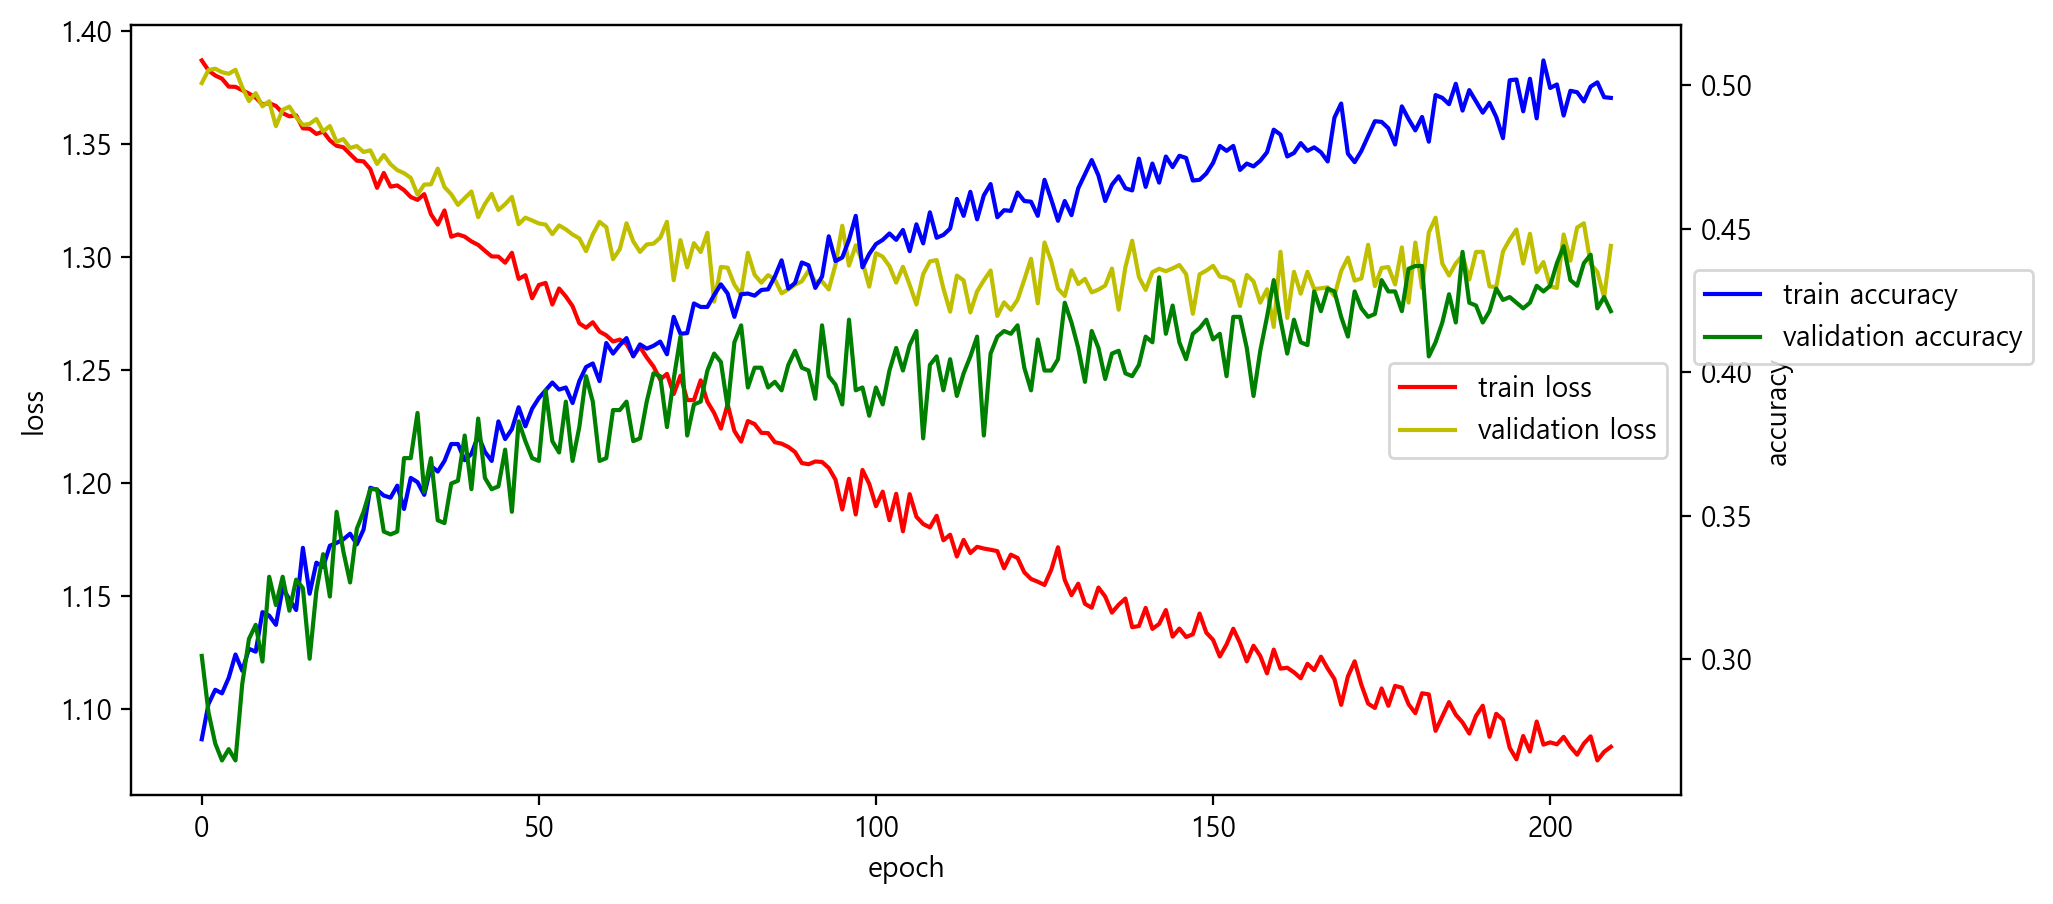

In [121]:
# 학습과정 표시하기
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

### 재시작시

In [3]:
# movies, movies_drop, movies_mean
# movies.to_csv('result/movies.csv', index=False, encoding='utf-8')
# movies_mean.to_csv('result/movies_mean.csv', index=False, encoding='utf-8')
movies = pd.read_csv('result/movies.csv')
movies_mean = pd.read_csv('result/movies_mean.csv')
movies_mean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6037 entries, 0 to 6036
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   영화제목       6037 non-null   object 
 1   유통회사명      6037 non-null   object 
 2   개봉년도       6037 non-null   int64  
 3   개봉월        6037 non-null   int64  
 4   총스크린수      5632 non-null   float64
 5   관람객수       6037 non-null   float64
 6   장르         6037 non-null   object 
 7   등급         6037 non-null   object 
 8   네이버_평점     6037 non-null   float64
 9   씨네21_평점    6037 non-null   float64
 10  총스크린수_med  6037 non-null   float64
 11  평균평점       6037 non-null   float64
dtypes: float64(6), int64(2), object(4)
memory usage: 566.1+ KB
